This notebook provides a summary of the predictive analyses using task or survey data to predict demographic/health measures.  

In [96]:
import os,glob,sys
import pickle
import numpy,pandas
pandas.options.display.max_colwidth = 0
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
import seaborn as sns
import scipy.stats
from statsmodels.sandbox.stats.multicomp import multipletests
%load_ext rpy2.ipython
from scipy.cluster.hierarchy import dendrogram,ward,cut_tree,leaves_list
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

import selfregulation.prediction.behavpredict as behavpredict

clf='lasso'
acc,features=pickle.load(open('singularity_analyses/wrangler/%s_data_collapsed.pkl'%clf,'rb'))
cont_measure='r2' # use r^2 or MAE for non-binary variables

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Check all variables to make sure they have the correct number of observations (1000 for baseline and baseline_shuffle, 100 for all others), and create tables summarizing data.

In [112]:
allvars={}
datasets=[]
for k in acc.keys():
    if len(acc[k])==0:
        print('no data for',k)
        continue
    datasets.append(k)
    for v in acc[k][cont_measure]['scores_cv']:
        allvars[v]=cont_measure
    for v in acc[k]['AUROC']['scores_cv']:
        allvars[v]='AUROC'

alldata={'r2':pandas.DataFrame(),'MAE':pandas.DataFrame(),'AUROC':pandas.DataFrame(),
        'r2_pval':pandas.DataFrame()}
#['baseline_shuffle','baseline','task','survey','discounting',
#          'stopping','intelligence',
#          'impulsivity','big5','risktaking','grit','emotion','bisbas',
#          'drift','nondecision','thresh']
target_n={}
goodcount={}
for d in datasets:
    if len(acc[k])==0:
        print('no data for',k)
        continue
    
    goodcount[d]={}
    if d.find('baseline')>-1:
        target_n[d]=1000
    else:
        target_n[d]=100
    examplefeature=list(features[d].keys())[0]
    print(d,features[d][examplefeature].shape[1])

    for v in acc[d]['r2']['scores_cv']:
        if not v in acc[d][allvars[v]]['scores_cv']:
            goodcount[d][v]=0
        else:
            goodcount[d][v]=numpy.isfinite(acc[d][allvars[v]]['scores_cv'][v]).sum()
        if goodcount[d][v]<target_n[d]:
            print(d,v,goodcount[d][v],features[d][v].shape[1])

for v in allvars:
    if allvars[v]==cont_measure:
        vars={}
        for k in datasets:
            if not 'r2' in acc[k]:
                continue
            vars[k]=acc[k]['r2']['scores_cv'].mean().T
        df=pandas.DataFrame(vars,index=[v])
        alldata['r2']=alldata['r2'].append(df)
        
        vars={}
        for k in datasets:
            if not 'MAE' in acc[k]:
                continue
            vars[k]=acc[k]['MAE']['scores_cv'].mean().T
        df=pandas.DataFrame(vars,index=[v])
        alldata['MAE']=alldata['MAE'].append(df)
    else:
        vars={}
        for k in datasets:
            if not 'AUROC' in acc[k]:
                continue
            vars[k]=acc[k]['AUROC']['scores_cv'].mean().T
        df=pandas.DataFrame(vars,index=[v])
        alldata['AUROC']=alldata['AUROC'].append(df)
   


no data for emotion
intelligence 5
stroop 6
nondecision 15
stopping 14
stop_signal 8
bisbas 6
grit 3
discounting 8
threebytwo 6
attention_network_task 8
motor_selective_stop_signal 2
discount_titrate 3
thresh 15
risktaking 21
baseline_shuffle 2
baseline_shuffle DivorceCount 999 2
tower_of_london 6
dot_pattern_expectancy 9
baseline 2
kirby 5
big5 7
task 107
task HowOftenGuiltRemorseDrinking 33 107
task AlcoholHowOften6Drinks 40 107
task HowOftenFailedActivitiesDrinking 24 107
impulsivity 13
survey 67
drift 27
columbia_card_task_hot 7


Compute p values

In [118]:
target='baseline'
null='baseline_shuffle'
def get_pval(target,null,allvars,datasets,acc):
    data=[]
    vars=list(allvars.keys())
    vars.sort()
    for v in vars:
        #print(target,null,v)
        if not v in acc[target][allvars[v]]['scores_cv'] or not v in acc[null][allvars[v]]['scores_cv']:
            data.append([allvars[v],numpy.nan,numpy.nan,numpy.nan,numpy.nan,numpy.nan])
            continue
        targdist=acc[target][allvars[v]]['scores_cv'][v].dropna()
        targmean=targdist.mean()
        nulldist=acc[null][allvars[v]]['scores_cv'][v].dropna()
        nullmean=nulldist.mean()
        targstd=targdist.std()
        pval=1-scipy.stats.percentileofscore(nulldist,targmean)/100.
        if targstd>0:
            #es=(targmean-nullmean)/targstd
            es=targmean-nullmean
        else:
            es=numpy.nan
        insample=acc[target][allvars[v]]['scores_insample'][v].mean()
        data.append([allvars[v],targmean,nullmean,es,insample,pval])
    df=pandas.DataFrame(data,index=vars,columns=['Measure','Target mean','Null Mean','Effect size','In-sample','p_unc'])
    return(df)
        
pvals={}
pvals[('baseline','baseline_shuffle')]=get_pval('baseline','baseline_shuffle',allvars,datasets,acc)
for d in datasets:
    if d.find('baseline')>-1 or len(acc[d])==0:
        continue
    print(d)
    pvals[(d,'baseline')]=get_pval(d,'baseline',allvars,datasets,acc)

pvals_fdr={}
for k in pvals:
    tmp=multipletests(pvals[k]['p_unc'])
    pvals[k]['p_fdr']=tmp[1]

intelligence
stroop
nondecision
stopping
stop_signal
bisbas
grit
discounting
threebytwo
attention_network_task
motor_selective_stop_signal
discount_titrate
thresh
risktaking
tower_of_london
dot_pattern_expectancy
kirby
big5
task
impulsivity
survey
drift
columbia_card_task_hot


In [5]:
def get_importances(v,dt,features,nfeats=3):
    if not v in features[dt]:
        print(v,'is not in features for',dt)
        return None
    
    #print(dt,'importances for:',v)
    imp=pandas.DataFrame({'importance':(features[dt][v].abs()>0).mean(0)})
    imp['mean']=features[dt][v].mean(0)
    imp=imp.sort_values(by='importance',ascending=False)
    
    if nfeats>(imp.shape[0]):
        nfeats=imp.shape[0]
    topfeats=imp.iloc[:nfeats]
    topfeats=topfeats.query('importance>0')
    return topfeats

def get_importance_list(sigp,dt,features):
    implist=[]
    for v in sigp.index:
        i=get_importances(v,dt,features)
        implist.append([list(i.index)])
    df=pandas.DataFrame({'top features':implist})
    df.index=sigp.index
    return df

# plot var for all datasets
def plotvars(v,pvals,datasets,allvars,plotcutoff=True,
            plotbaseline=False):

    df=[]
    errors=[]
    ds=[]
    for k in datasets:
        if not allvars[v] in acc[k]:
            continue
        if not v in acc[k][allvars[v]]['scores_cv']:
            continue
        targdist=acc[k][allvars[v]]['scores_cv'][v].dropna()
        df.append(targdist.mean())
        ds.append(k)
        errors.append(targdist.std())
    df=pandas.DataFrame({'mean':df},index=ds)
    errors=pandas.DataFrame({'mean':errors},index=ds)
    if allvars[v]=='AUROC':
        df.plot.bar(yerr=errors,legend=False,ylim=(0.45,numpy.max(df.values)*1.1))
    else:
        df.plot.bar(yerr=errors,legend=False)
    plt.title(v)
    plt.ylabel(allvars[v]+' +/- SE across CV runs')
    if plotcutoff:
        cutoff=acc['baseline'][allvars[v]]['scores_cv'][v].dropna().quantile(0.95)
        plt.plot([0,1000],[cutoff,cutoff],'k--',linewidth=0.5)
    if plotbaseline:
        baseline=acc['baseline'][allvars[v]]['scores_cv'][v].dropna().mean()
        plt.plot([0,1000],[baseline,baseline],'k--',linewidth=0.5)


## List all variables showing activity greater for baseline model vs shuffled model

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
Age,r2,1.000000,0.002725,0.997275,1.000000,0.0,0.0,[[Age]]
HeightInches,r2,0.379233,0.002766,0.376466,0.387085,0.0,0.0,"[[Sex, Age]]"
LongestRelationship,r2,0.267142,0.002867,0.264276,0.274270,0.0,0.0,"[[Age, Sex]]"
DivorceCount.binarized,AUROC,0.736961,0.499135,0.237826,0.549379,0.0,0.0,"[[Age, Sex]]"
ChildrenNumber.binarized,AUROC,0.695951,0.497903,0.198048,0.646124,0.0,0.0,"[[Age, Sex]]"
DivorceCount,r2,0.177983,0.002890,0.175093,0.204752,0.0,0.0,"[[Age, Sex]]"
RelationshipNumber,r2,0.154190,0.002797,0.151393,0.162268,0.0,0.0,"[[Age, Sex]]"
ChildrenNumber,r2,0.127504,0.002880,0.124623,0.138086,0.0,0.0,"[[Sex, Age]]"
RetirementPercentStocks.binarized,AUROC,0.623150,0.501566,0.121584,0.497496,0.0,0.0,"[[Age, Sex]]"
RelationshipStatus.binarized,AUROC,0.620574,0.499214,0.121360,0.620904,0.0,0.0,"[[Sex, Age]]"


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


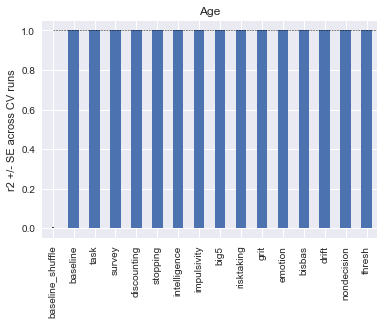

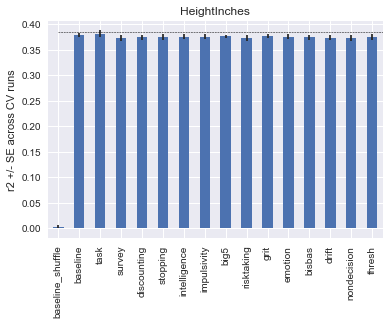

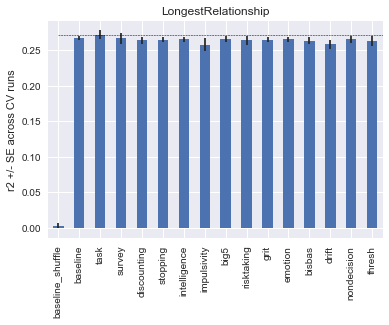

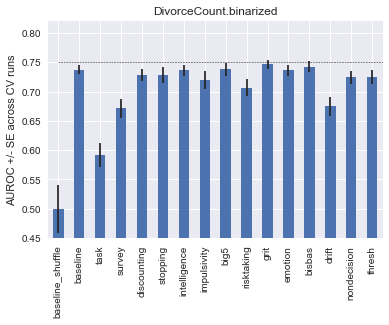

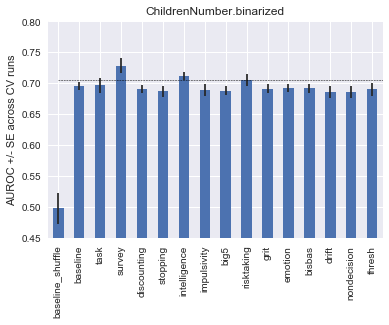

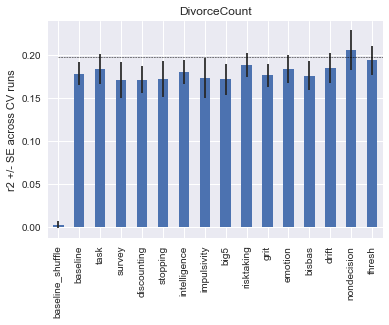

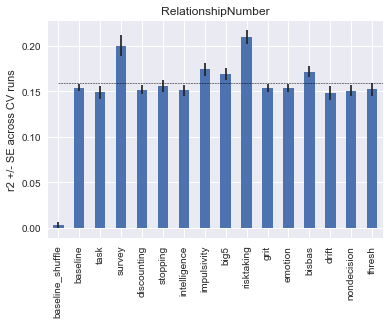

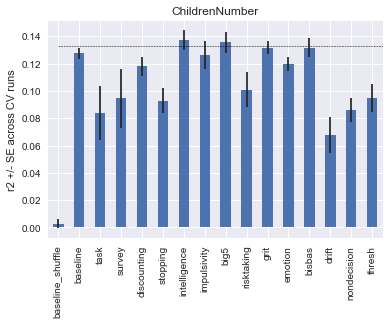

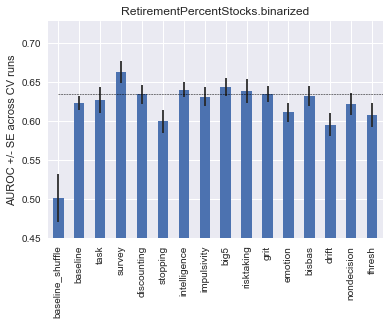

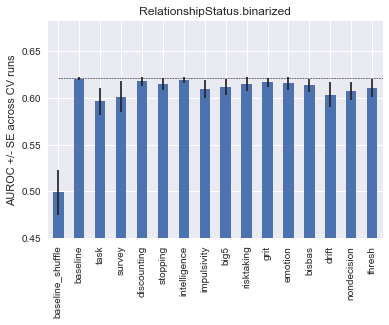

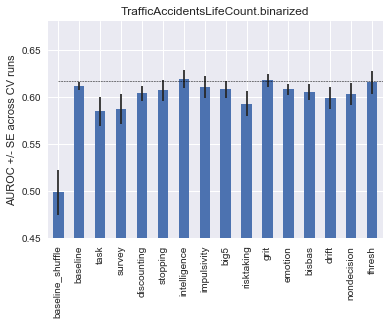

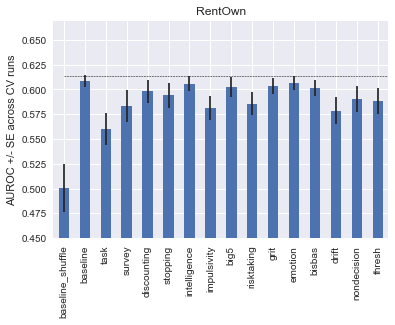

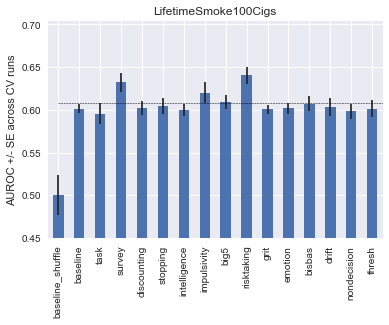

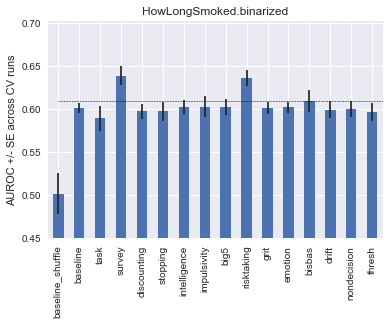

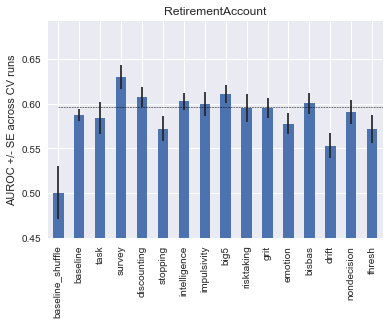

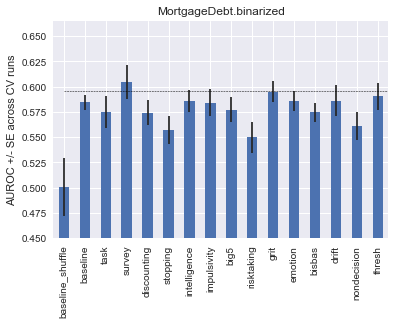

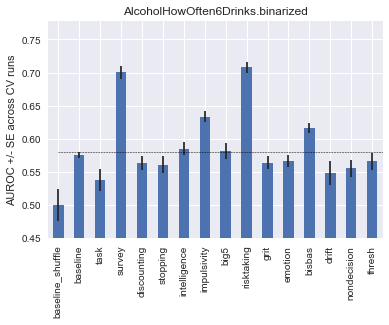

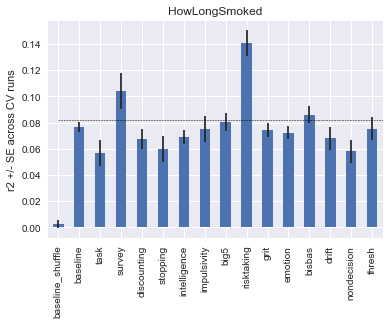

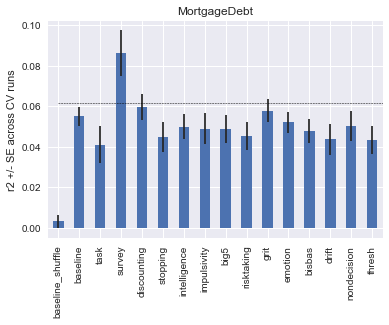

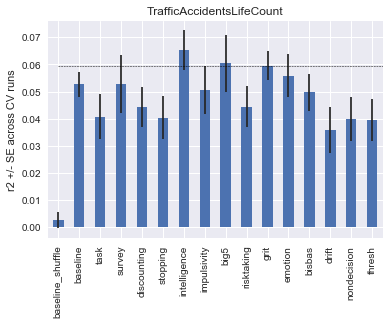

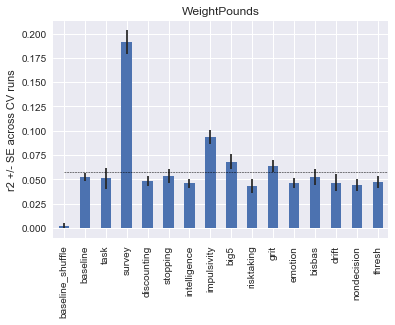

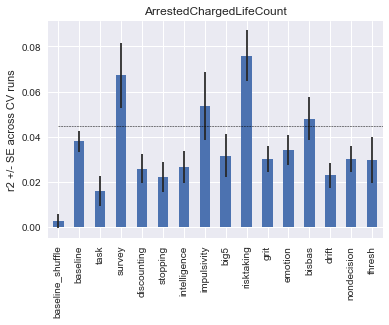

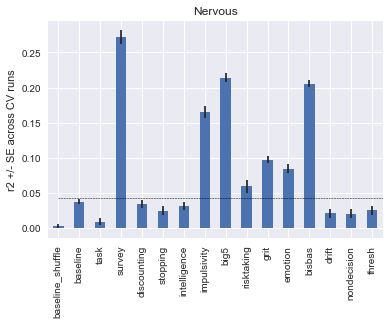

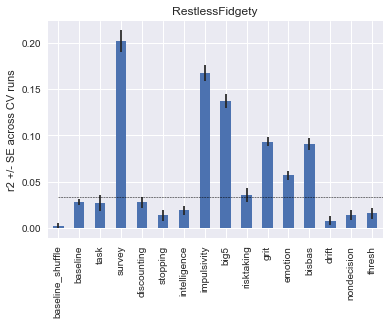

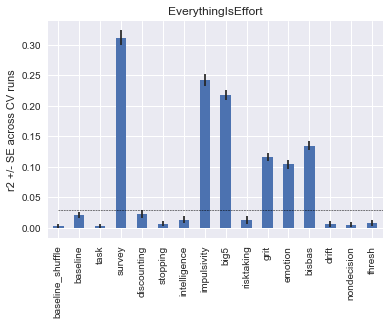

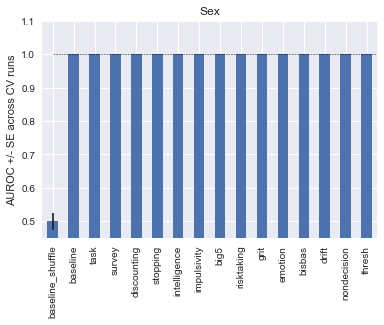

In [6]:
sigp={}
pthresh=0.05
k=('baseline','baseline_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)

In [7]:
get_importances('Obese','survey',features)

,importance,mean
five_facet_mindfulness_survey.observe,1.0,-0.269396
dospert_rp_survey.recreational,1.0,0.392616
time_perspective_survey.past_negative,1.0,-0.354049


## Example of overfitting

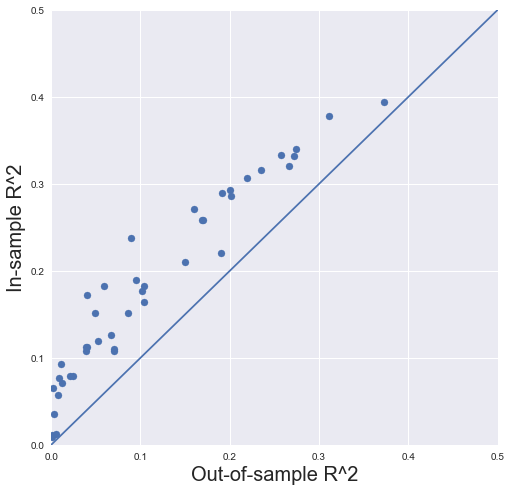

In [8]:
k=('survey','baseline')
plt.figure(figsize=(8,8))
r2data=pvals[k].query('Measure == "r2"')
plt.scatter(r2data['Target mean'],r2data['In-sample'])
plt.plot([0,1],[0,1])
plt.axis([0,0.5,0,0.5])
plt.xlabel('Out-of-sample R^2',fontsize=20)
plt.ylabel('In-sample R^2',fontsize=20)
plt.savefig('overfitting.png',dpi=300)

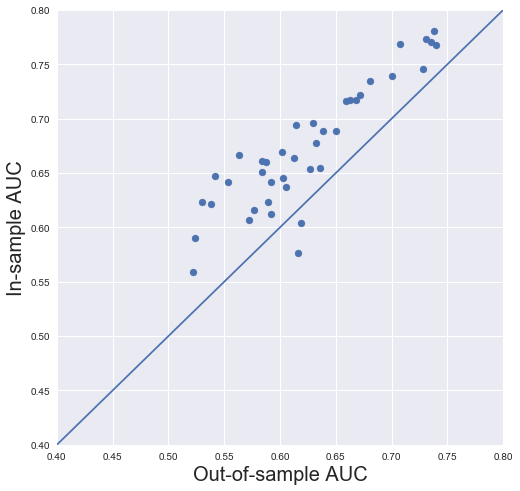

In [34]:
k=('survey','baseline')
plt.figure(figsize=(8,8))
r2data=pvals[k].query('Measure == "AUROC"')
plt.scatter(r2data['Target mean'],r2data['In-sample'])
plt.plot([0,1],[0,1])
plt.axis([0.4,0.8,0.4,.8])
plt.xlabel('Out-of-sample AUC',fontsize=20)
plt.ylabel('In-sample AUC',fontsize=20)
plt.savefig('overfitting_AUC.png',dpi=300)


## Show variables with greater prediction for survey vs. baseline

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
EverythingIsEffort,r2,0.311615,0.021692,0.289923,0.378363,0.000,0.000000,"[[mindful_attention_awareness_survey.mindfulness, ten_item_personality_survey.emotional_stability, upps_impulsivity_survey.lack_of_premeditation]]"
Worthless,r2,0.274290,0.009320,0.264970,0.340033,0.000,0.000000,"[[five_facet_mindfulness_survey.nonjudge, time_perspective_survey.past_negative, ten_item_personality_survey.emotional_stability]]"
Hopeless,r2,0.257543,0.013748,0.243795,0.333058,0.000,0.000000,"[[Age, future_time_perspective_survey.future_time_perspective, ten_item_personality_survey.emotional_stability]]"
Nervous,r2,0.271560,0.037322,0.234237,0.332014,0.000,0.000000,"[[ten_item_personality_survey.emotional_stability, bis_bas_survey.BIS, time_perspective_survey.past_negative]]"
Depressed,r2,0.234864,0.006879,0.227986,0.316230,0.000,0.000000,"[[ten_item_personality_survey.emotional_stability, time_perspective_survey.past_negative, selection_optimization_compensation_survey.optimization.ReflogTr]]"
DaysHalfLastMonth,r2,0.219263,0.001559,0.217704,0.306949,0.000,0.000000,"[[selection_optimization_compensation_survey.optimization.ReflogTr, bis_bas_survey.BIS, time_perspective_survey.past_negative]]"
Hopeless.binarized,AUROC,0.740134,0.540419,0.199716,0.767312,0.000,0.000000,"[[time_perspective_survey.past_negative, ten_item_personality_survey.emotional_stability, five_facet_mindfulness_survey.nonjudge]]"
AlcoholHowManyDrinksDay,r2,0.189819,0.002484,0.187335,0.220110,0.000,0.000000,"[[sensation_seeking_survey.disinhibition, dospert_rt_survey.health_safety, dospert_eb_survey.health_safety.logTr]]"
EverythingIsEffort.binarized,AUROC,0.737792,0.554889,0.182903,0.780408,0.000,0.000000,"[[five_facet_mindfulness_survey.act_with_awareness, bis_bas_survey.BIS, time_perspective_survey.past_negative]]"
Worthless.binarized,AUROC,0.735083,0.552286,0.182798,0.770051,0.000,0.000000,"[[time_perspective_survey.past_negative, self_regulation_survey.control, five_facet_mindfulness_survey.nonjudge]]"


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


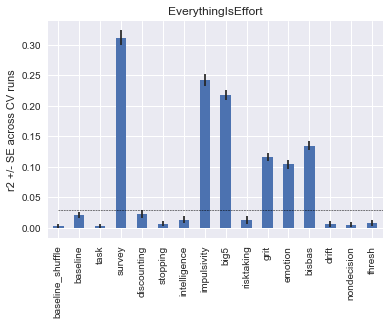

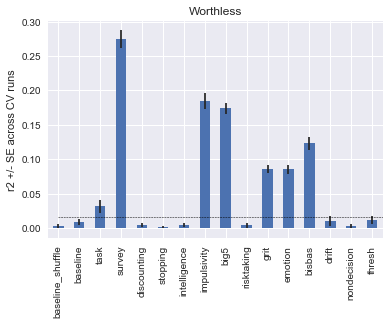

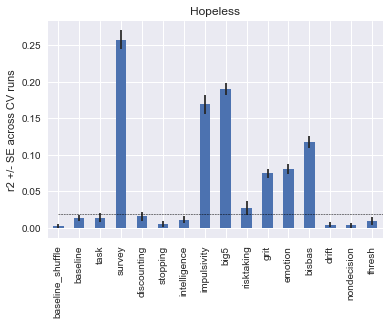

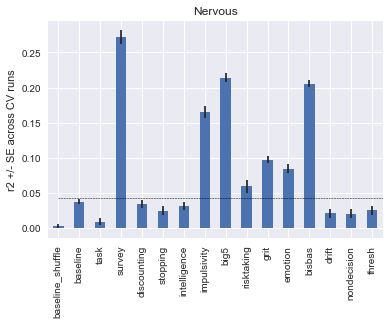

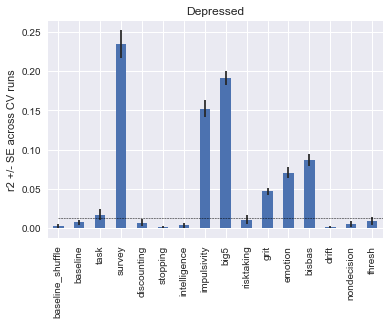

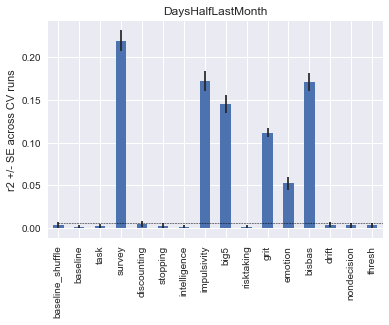

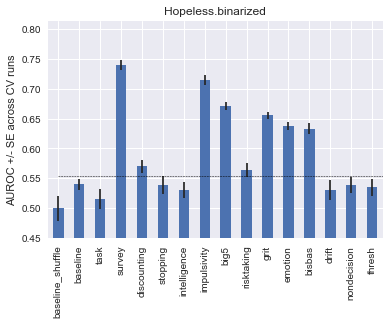

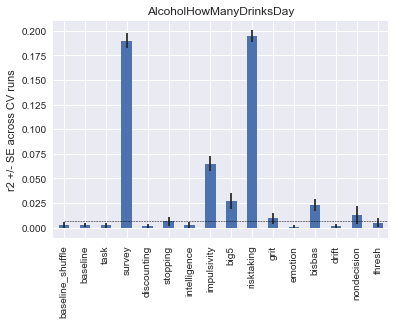

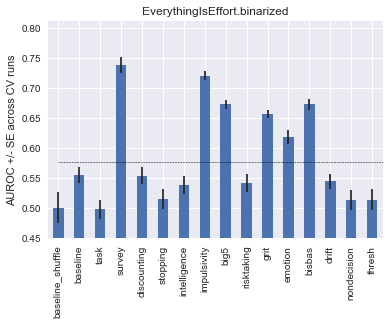

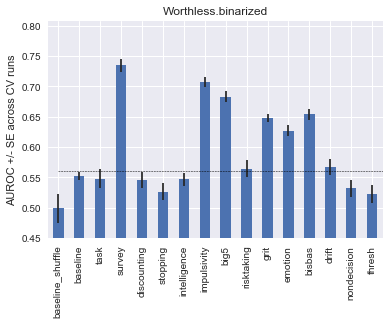

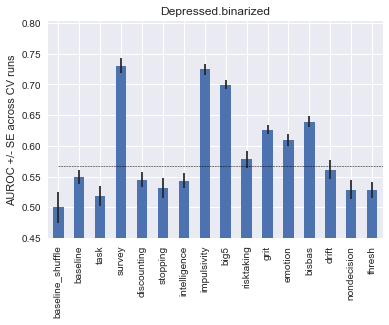

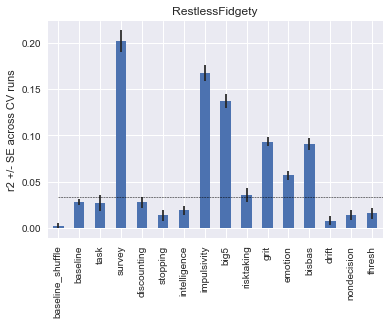

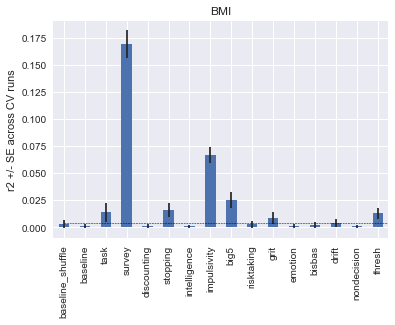

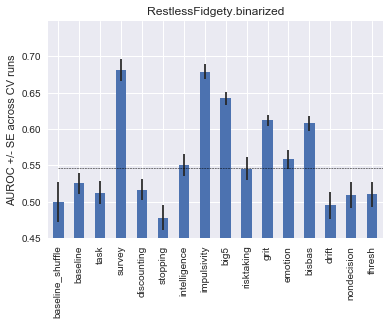

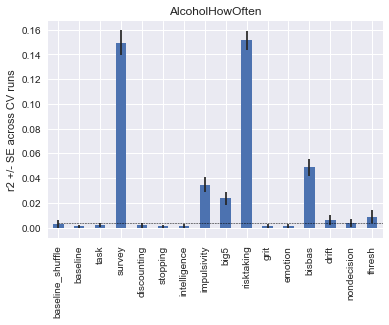

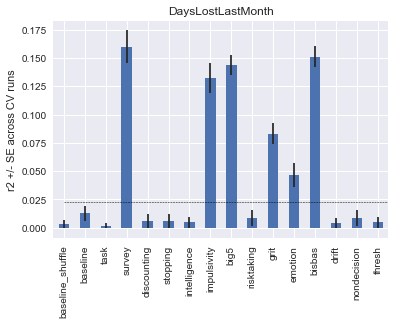

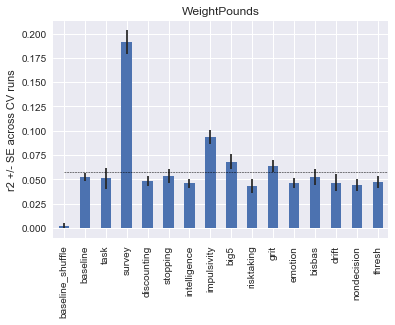

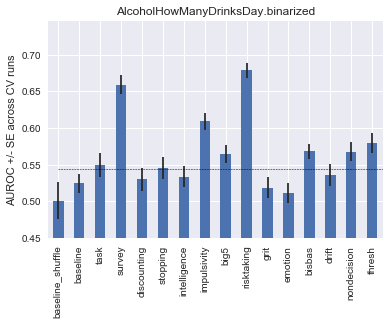

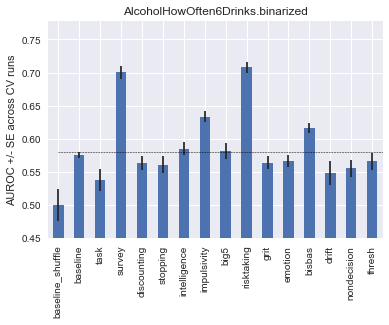

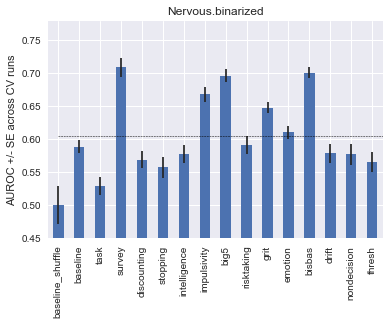

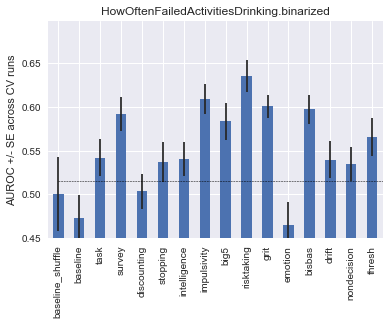

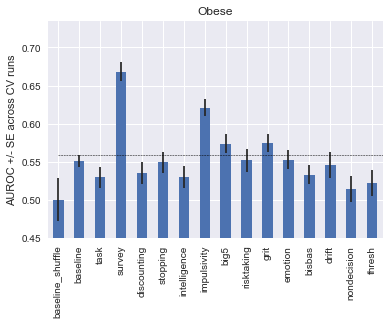

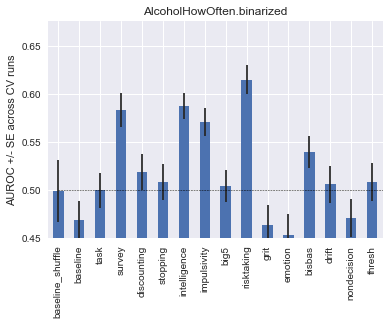

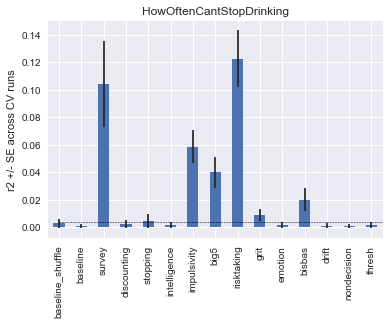

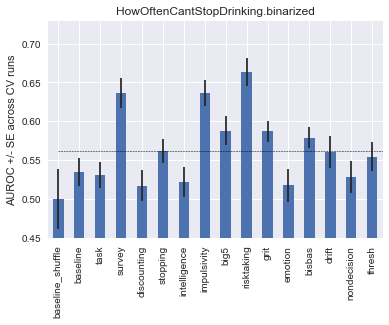

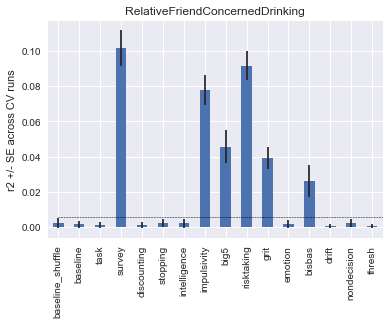

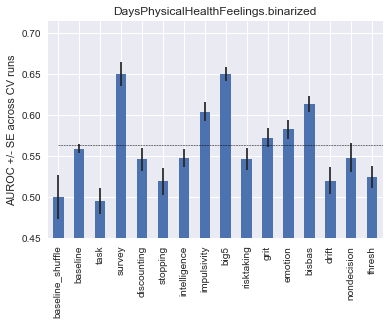

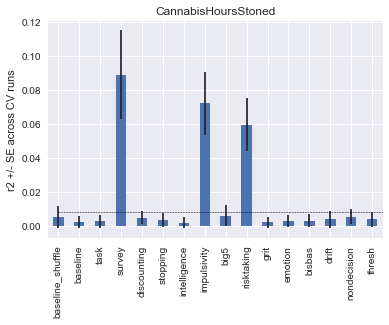

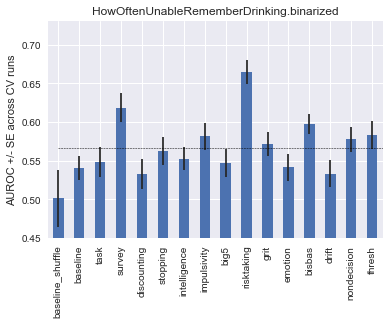

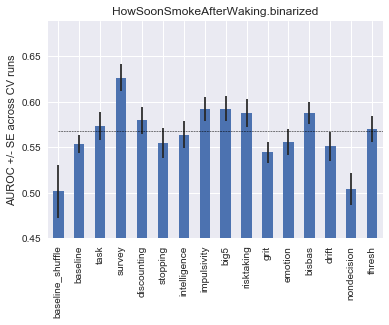

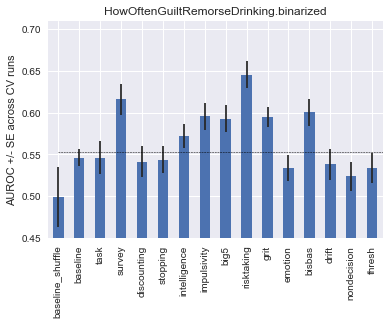

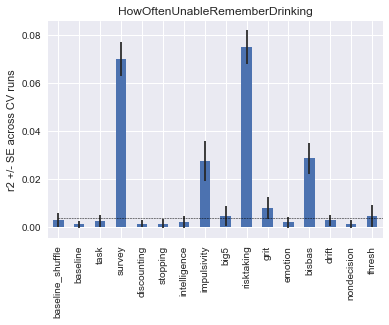

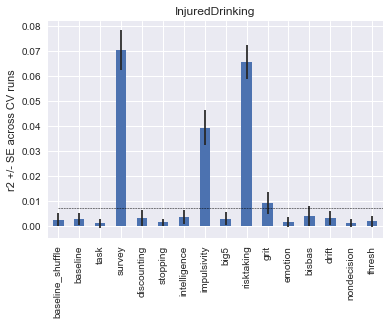

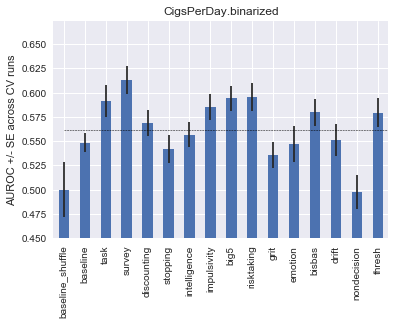

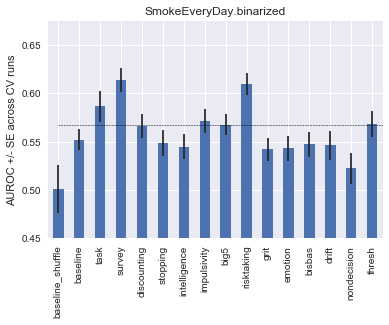

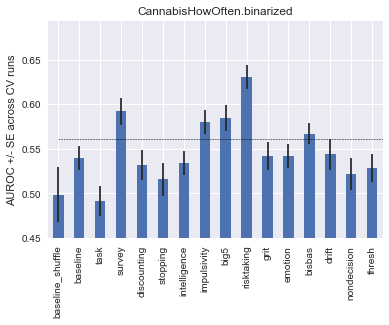

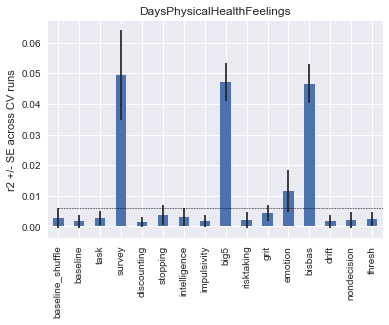

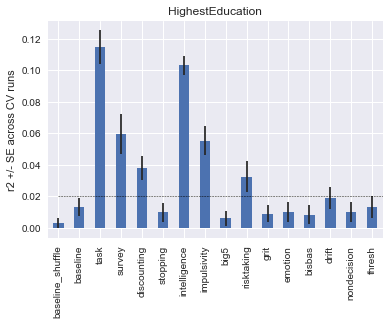

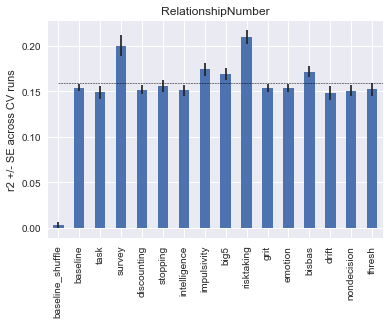

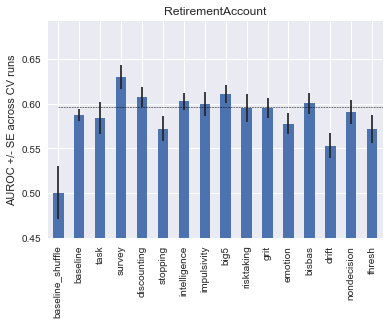

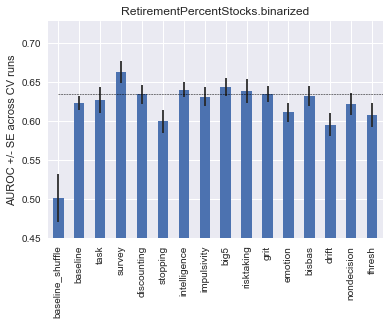

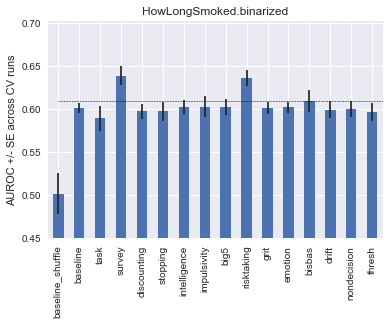

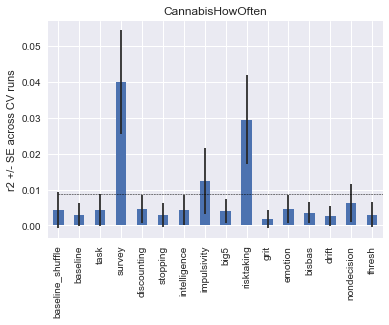

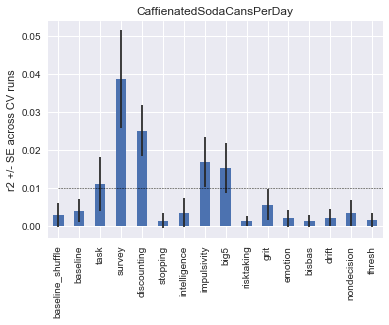

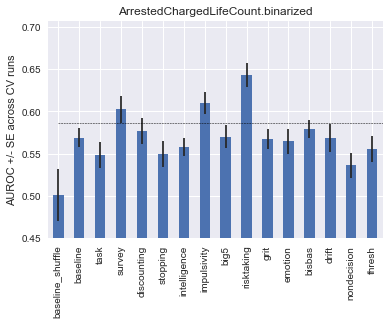

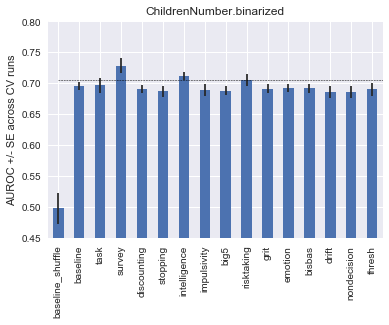

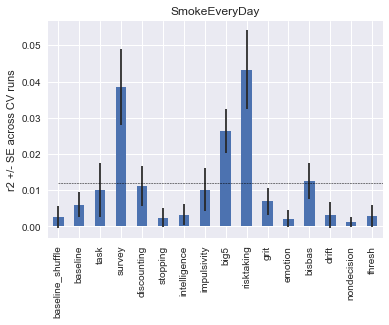

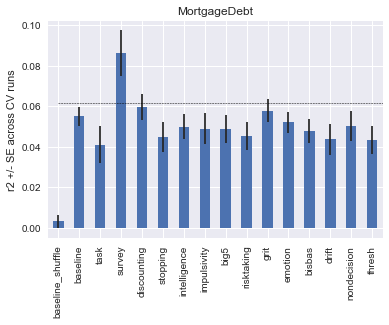

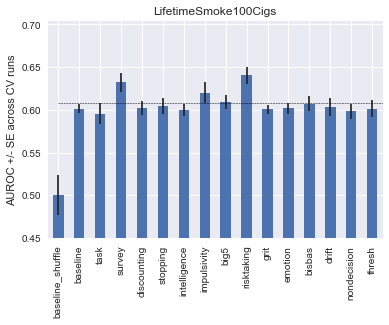

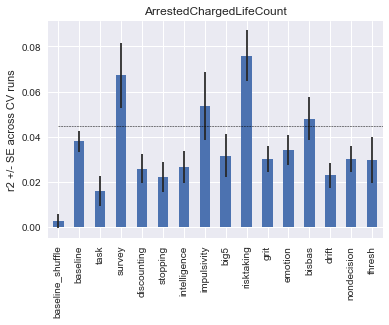

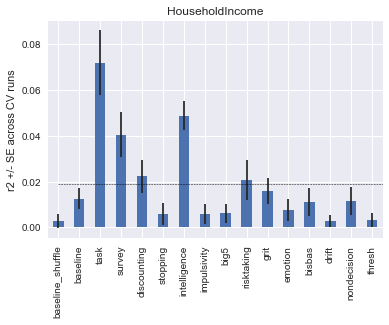

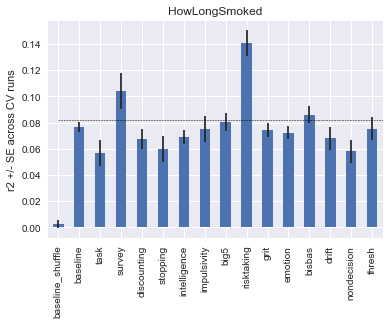

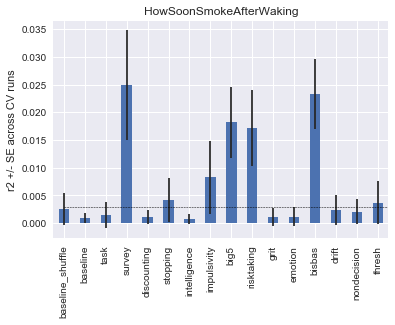

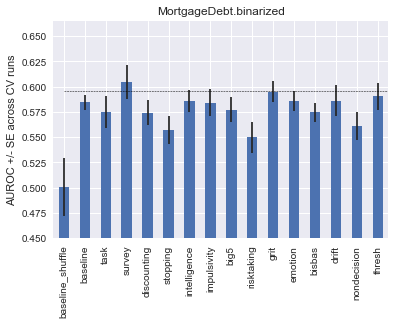

In [9]:
k=('survey','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)

## Show variables with greater prediction for task vs. baseline

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
HighestEducation,r2,0.114616,0.013093,0.101522,0.174833,0.0,0.0,"[[cognitive_reflection_survey.correct_proportion, bickel_titrator.hyp_discount_rate_medium.logTr, writing_task.positive_probability]]"
HouseholdIncome,r2,0.071924,0.012531,0.059393,0.169149,0.0,0.0,"[[cognitive_reflection_survey.correct_proportion, writing_task.positive_probability, writing_task.neutral_probability]]"
CigsPerDay.binarized,AUROC,0.590894,0.548350,0.042544,0.718088,0.0,0.0,"[[information_sampling_task.Fixed_Win_motivation, stop_signal.SSRT_low, information_sampling_task.Fixed_Win_P_correct]]"
SmokeEveryDay.binarized,AUROC,0.586648,0.551976,0.034672,0.716365,0.0,0.0,"[[information_sampling_task.Fixed_Win_motivation, simon.hddm_thresh, kirby.hyp_discount_rate_large.logTr]]"
Worthless,r2,0.031514,0.009320,0.022194,0.099400,0.0,0.0,"[[writing_task.positive_probability, threebytwo.hddm_thresh, Age]]"
BMI,r2,0.013975,0.001352,0.012624,0.120456,0.0,0.0,"[[stim_selective_stop_signal.hddm_thresh.logTr, dietary_decision.health_sensitivity, stroop.hddm_drift]]"
Depressed,r2,0.017024,0.006879,0.010145,0.069813,0.0,0.0,"[[writing_task.positive_probability, threebytwo.hddm_thresh, choice_reaction_time.hddm_drift]]"


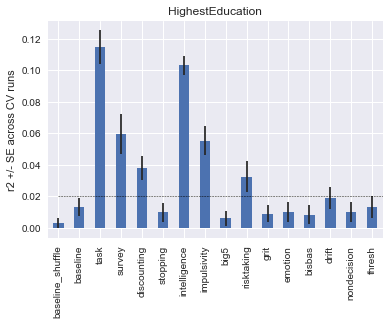

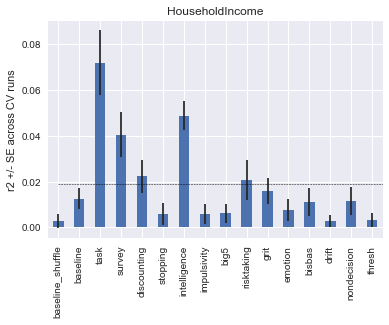

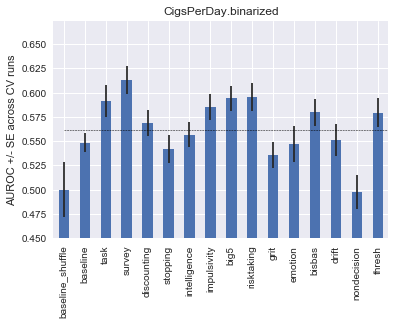

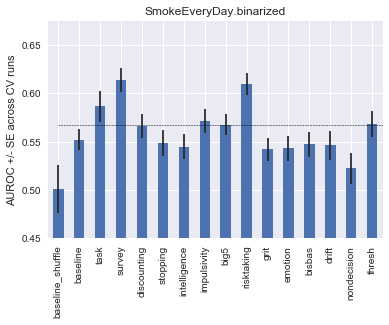

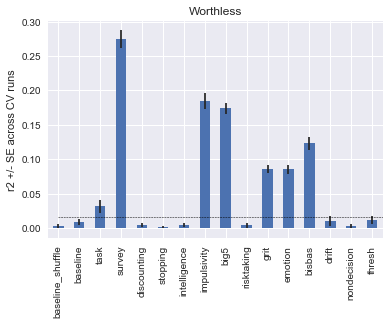

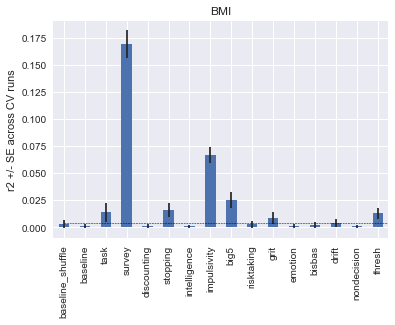

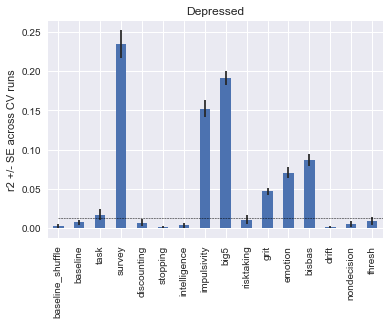

In [10]:
k=('task','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)

### Make figure for paper

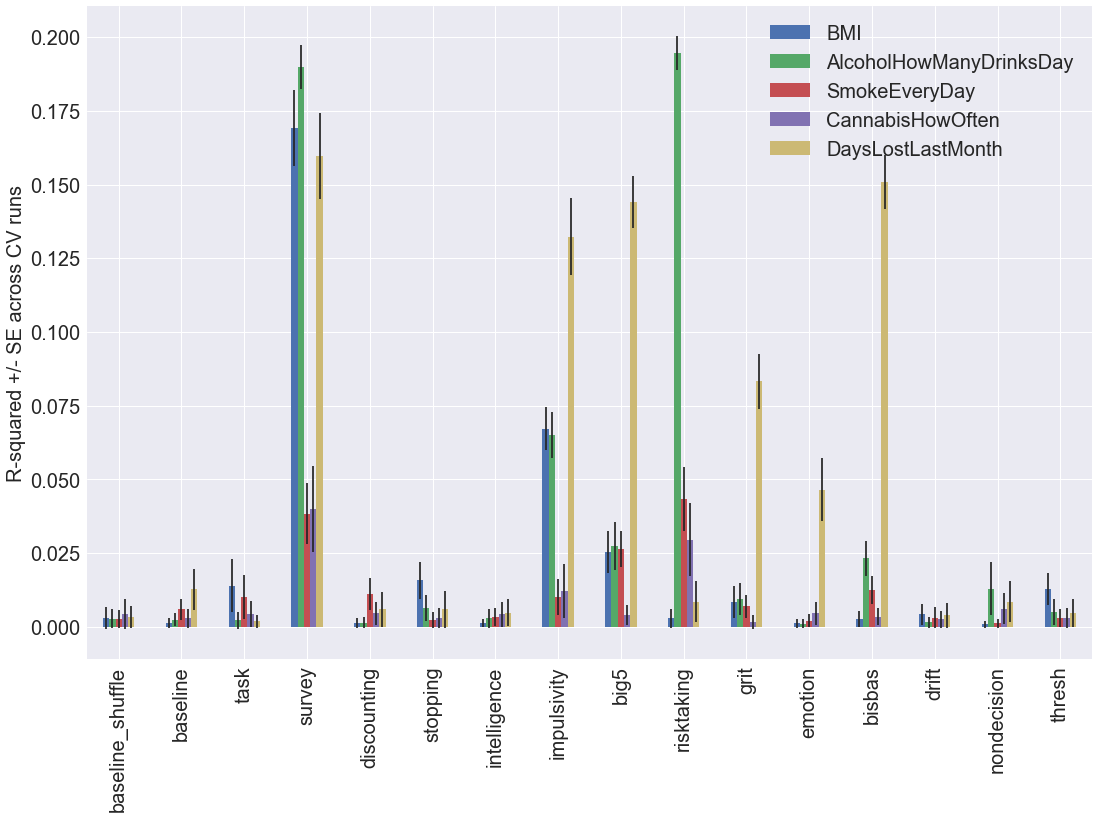

In [11]:
figurevars=['BMI','AlcoholHowManyDrinksDay','SmokeEveryDay',
            'CannabisHowOften','DaysLostLastMonth']


def plot_paper_vars(vars,pvals,datasets,allvars):
    f, axarr = plt.subplots(2, 2,figsize=(18,16))
    xy=[[0,0],[0,1],[1,0],[1,1]]
    ctr=0
    for v in vars:
        df=[]
        errors=[]
        ds=[]
        for k in datasets:
            if not allvars[v] in acc[k]:
                continue
            if not v in acc[k][allvars[v]]['scores_cv']:
                continue
            targdist=acc[k][allvars[v]]['scores_cv'][v].dropna()
            df.append(targdist.mean())
            ds.append(k)
            errors.append(targdist.std())
        df=pandas.DataFrame({'mean':df},index=ds)
        errors=pandas.DataFrame({'mean':errors},index=ds)
        if allvars[v]=='AUROC':
            df.plot.bar(yerr=errors,legend=False,
                    ylim=(0.45,numpy.max(df.values)*1.1),
                        ax=axarr[xy[ctr][0],xy[ctr][1]],
                       title=v)
        else:
            df.plot.bar(yerr=errors,legend=False,
                        ax=axarr[xy[ctr][0],xy[ctr][1]],
                       title=v)
        if xy[ctr][0]==0:
            x_axis = axarr[xy[ctr][0],xy[ctr][1]].axes.get_xaxis()
            x_axis.set_visible(False)
        if xy[ctr][1]==0:
            plt.ylabel(allvars[v]+' +/- SE across CV runs')
        ctr+=1
                                                                  
vars=figurevars        
#def plot_paper_vars2(vars,pvals,datasets,allvars):
if 1:
    f= plt.figure(figsize=(18,12))
    ax=plt.gca()
    data=None
    errors=None
    for v in vars:
        df=[]
        err=[]
        ds=[]
        for k in datasets:
            if not allvars[v] in acc[k]:
                continue
            if not v in acc[k][allvars[v]]['scores_cv']:
                continue
            targdist=acc[k][allvars[v]]['scores_cv'][v].dropna()
            df.append(targdist.mean())
            ds.append(k)
            err.append(targdist.std())
        if data is None:
            data=pandas.DataFrame({v:df},index=ds)
            errors=pandas.DataFrame({v:err},index=ds)
        else:
            data[v]=pandas.DataFrame({v:df},index=ds)
            errors[v]=pandas.DataFrame({v:err},index=ds)
            
    if allvars[v]=='AUROC':
        data.plot.bar(yerr=errors,legend=True,
                ylim=(0.45,numpy.max(df.values)*1.1),
                   title=v,ax=ax,fontsize=20)
    else:
        data.plot.bar(yerr=errors,
                   ax=ax,fontsize=20)
    plt.ylabel('R-squared +/- SE across CV runs',fontsize=20)
    plt.legend(fontsize=20)                               

#plot_paper_vars(figurevars,pvals,datasets,allvars)
plt.savefig('barplots.png',dpi=300)

## Show variables with greater prediction for DDM parameters vs. baseline

### drift

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
CaffieneOtherSourcesDayMG,r2,0.015254,0.005292,0.009962,0.042369,0.0,0.0,"[[recent_probes.hddm_drift, directed_forgetting.hddm_drift, Sex]]"


CaffieneOtherSourcesDayMG
                                importance       mean
recent_probes.hddm_drift        0.908333   -13.425610
directed_forgetting.hddm_drift  0.608333   -4.192041 
Sex                             0.450000   -2.824963 



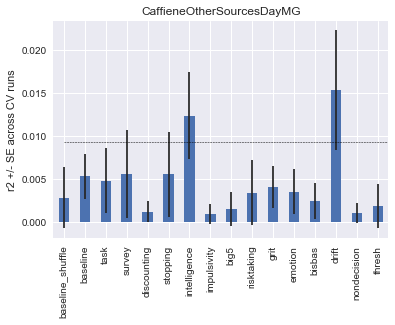

In [12]:
k=('drift','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)
    print(v)
    print(get_importances(v,k[0],features)  )  
    print('')    


### Threshold

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
HowOftenFailedActivitiesDrinking.binarized,AUROC,0.565401,0.472534,0.092867,NaN,0.0,0.0,"[[adaptive_n_back.hddm_thresh, attention_network_task.hddm_thresh, choice_reaction_time.hddm_thresh]]"
AlcoholHowManyDrinksDay.binarized,AUROC,0.579236,0.524419,0.054817,0.534552,0.0,0.0,"[[adaptive_n_back.hddm_thresh, Age, threebytwo.hddm_thresh]]"
HowOftenUnableRememberDrinking.binarized,AUROC,0.583655,0.540953,0.042703,0.506989,0.0,0.0,"[[attention_network_task.hddm_thresh, dot_pattern_expectancy.hddm_thresh, recent_probes.hddm_thresh]]"
CigsPerDay.binarized,AUROC,0.579257,0.548350,0.030908,0.524938,0.0,0.0,"[[adaptive_n_back.hddm_thresh, attention_network_task.hddm_thresh, simon.hddm_thresh]]"
BMI,r2,0.012906,0.001352,0.011555,0.028645,0.0,0.0,"[[stim_selective_stop_signal.hddm_thresh.logTr, Age, Sex]]"


HowOftenFailedActivitiesDrinking.binarized
                                    importance      mean
adaptive_n_back.hddm_thresh         1.0         0.333080
attention_network_task.hddm_thresh  1.0        -0.271375
choice_reaction_time.hddm_thresh    1.0        -0.706958

AlcoholHowManyDrinksDay.binarized
                             importance      mean
adaptive_n_back.hddm_thresh  1.000000    0.502821
Age                          1.000000   -0.236964
threebytwo.hddm_thresh       0.991667   -0.267626

HowOftenUnableRememberDrinking.binarized
                                    importance      mean
attention_network_task.hddm_thresh  1.0        -0.213619
dot_pattern_expectancy.hddm_thresh  1.0        -0.292034
recent_probes.hddm_thresh           1.0         0.231322

CigsPerDay.binarized
                                    importance      mean
adaptive_n_back.hddm_thresh         1.0         0.311523
attention_network_task.hddm_thresh  1.0         0.283240
simon.hddm_thresh              

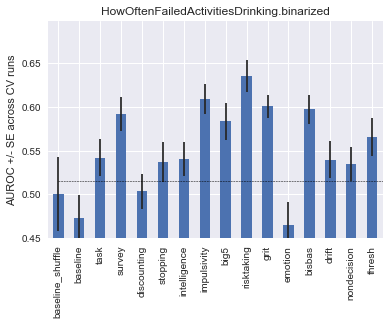

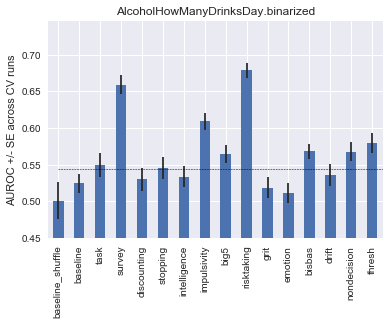

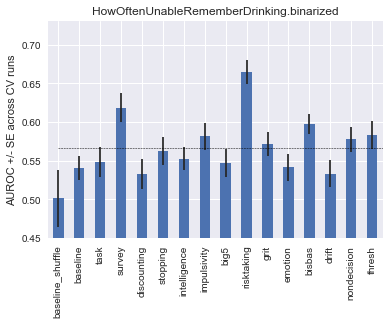

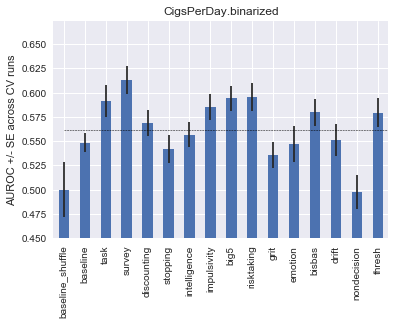

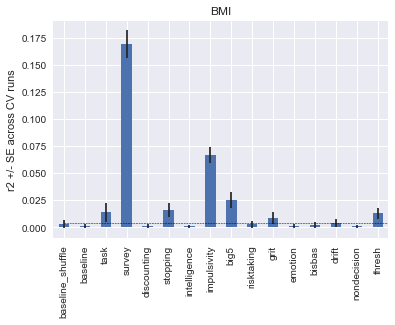

In [13]:
k=('thresh','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)
    print(v)
    print(get_importances(v,k[0],features)  )  
    print('')

### Nondecision time

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
AlcoholHowManyDrinksDay.binarized,AUROC,0.567682,0.524419,0.043264,0.530493,0.0,0.0,"[[simon.hddm_non_decision, threebytwo.hddm_non_decision, adaptive_n_back.hddm_non_decision]]"
AlcoholHowManyDrinksDay,r2,0.012914,0.002484,0.010430,0.064904,0.0,0.0,"[[simon.hddm_non_decision, threebytwo.hddm_non_decision, Sex]]"


AlcoholHowManyDrinksDay.binarized
                                   importance      mean
simon.hddm_non_decision            1.000000   -0.280247
threebytwo.hddm_non_decision       1.000000    0.386258
adaptive_n_back.hddm_non_decision  0.991667   -0.248047

AlcoholHowManyDrinksDay
                              importance      mean
simon.hddm_non_decision       0.833333   -0.077989
threebytwo.hddm_non_decision  0.783333    0.054360
Sex                           0.783333   -0.048559



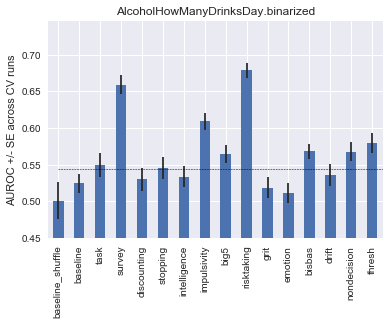

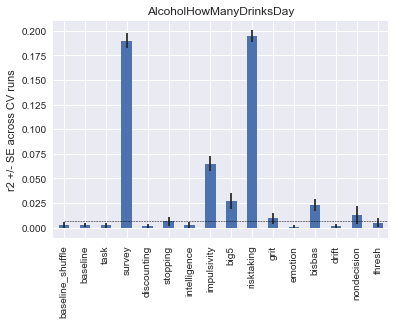

In [14]:
k=('nondecision','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)
    print(v)
    print(get_importances(v,k[0],features)  )  
    print('')

## Show variables with greater prediction for intelligence vs. baseline

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
AlcoholHowOften.binarized,AUROC,0.587700,0.468331,0.119369,NaN,0.0,0.0,"[[cognitive_reflection_survey.correct_proportion, ravens.score, Age]]"
HighestEducation,r2,0.103143,0.013093,0.090050,0.122951,0.0,0.0,"[[cognitive_reflection_survey.correct_proportion, Age, ravens.score]]"
HouseholdIncome,r2,0.048821,0.012531,0.036290,0.068739,0.0,0.0,"[[cognitive_reflection_survey.correct_proportion, Age, Sex]]"
HowOftenGuiltRemorseDrinking.binarized,AUROC,0.572284,0.546239,0.026046,NaN,0.0,0.0,"[[ravens.score, cognitive_reflection_survey.correct_proportion, Sex]]"
TrafficAccidentsLifeCount,r2,0.065180,0.052681,0.012499,0.087912,0.0,0.0,"[[ravens.score, Age, cognitive_reflection_survey.correct_proportion]]"
ChildrenNumber,r2,0.137056,0.127504,0.009552,0.163549,0.0,0.0,"[[cognitive_reflection_survey.correct_proportion, cognitive_reflection_survey.intuitive_proportion, ravens.score]]"


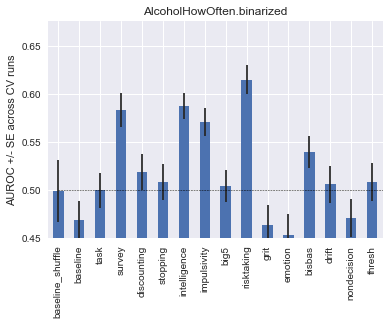

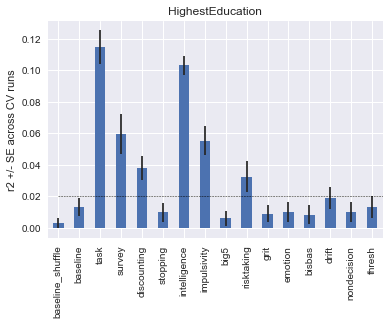

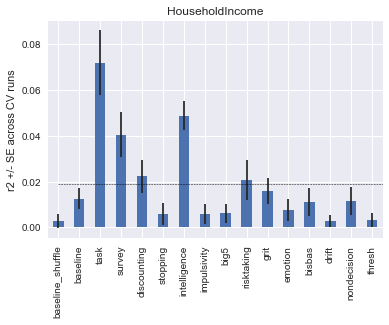

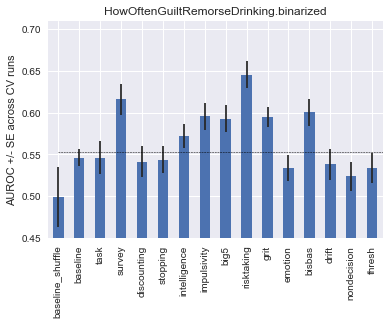

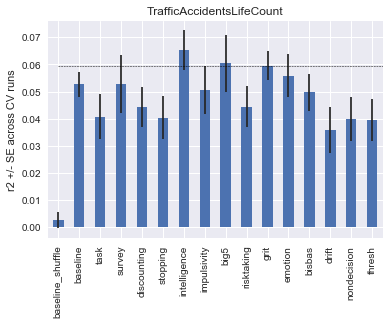

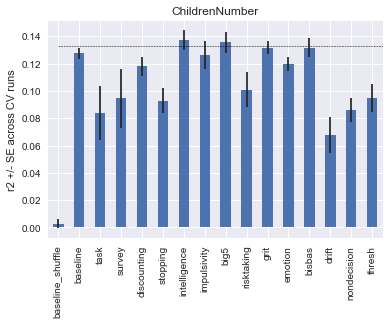

In [15]:
k=('intelligence','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)

## Show variables with greater prediction for stopping vs. baseline


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
BMI,r2,0.015769,0.001352,0.014417,0.052047,0.0,0.0,"[[stim_selective_stop_signal.hddm_thresh.logTr, stim_selective_stop_signal.hddm_drift, Age]]"


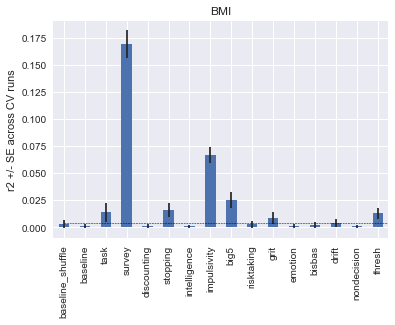

In [16]:
k=('stopping','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)

## Show variables with greater prediction for discounting vs. baseline


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
Hopeless.binarized,AUROC,0.570405,0.540419,0.029986,0.602704,0.0,0.0,"[[kirby.hyp_discount_rate_medium.logTr, Age, Sex]]"
HighestEducation,r2,0.037678,0.013093,0.024585,0.064696,0.0,0.0,"[[bickel_titrator.hyp_discount_rate_medium.logTr, Age, discount_titrate.percent_patient]]"
CaffienatedSodaCansPerDay,r2,0.025077,0.004000,0.021077,0.050963,0.0,0.0,"[[bickel_titrator.hyp_discount_rate_large.logTr, kirby.hyp_discount_rate_small.logTr, Age]]"
RetirementAccount,AUROC,0.607340,0.587012,0.020328,0.523538,0.0,0.0,"[[kirby.hyp_discount_rate_large.logTr, Age, bickel_titrator.hyp_discount_rate_medium.logTr]]"


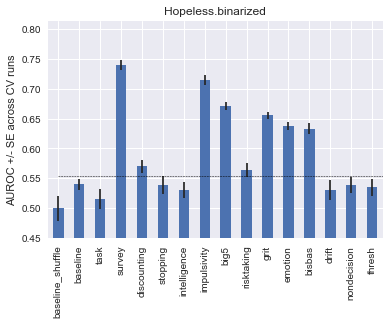

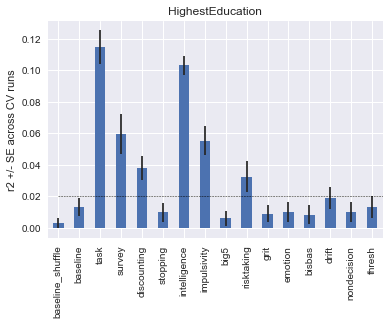

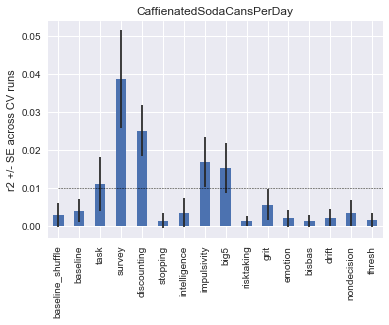

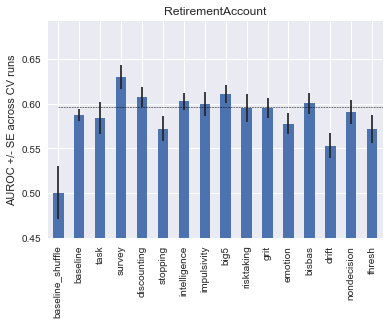

In [17]:
k=('discounting','baseline')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)

In [18]:
pvals[('discounting', 'baseline')]


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr
AbleToStopDrugs,AUROC,0.542715,0.559025,-1.631029e-02,NaN,0.845000,1.000000
Age,r2,1.000000,1.000000,3.742340e-12,1.000000,0.448000,1.000000
AlcoholHowManyDrinksDay,r2,0.001409,0.002484,-1.075442e-03,0.013912,0.563000,1.000000
AlcoholHowManyDrinksDay.binarized,AUROC,0.529832,0.524419,5.413181e-03,0.504276,0.351000,1.000000
AlcoholHowOften,r2,0.001785,0.001031,7.537737e-04,0.018484,0.198000,1.000000
AlcoholHowOften.binarized,AUROC,0.518941,0.468331,5.060967e-02,NaN,0.003003,0.225380
AlcoholHowOften6Drinks,r2,NaN,NaN,NaN,NaN,NaN,NaN
AlcoholHowOften6Drinks.binarized,AUROC,0.563249,0.575705,-1.245586e-02,0.564649,0.975000,1.000000
ArrestedChargedLifeCount,r2,0.025854,0.038000,-1.214638e-02,0.047791,0.988000,1.000000
ArrestedChargedLifeCount.binarized,AUROC,0.576802,0.568971,7.831136e-03,0.498780,0.237000,1.000000


### Assess survey variables in terms of their overall predictive utility


In [19]:
k=('survey','baseline')
df=pandas.DataFrame()
absfeat=pandas.DataFrame()

for v in features['survey']:
    df[v]=features['survey'][v].mean(0)
    absfeat[v]=(features['survey'][v].abs()>0).mean()
    
mean_imp=df.mean(1)
meanabs_survey=pandas.DataFrame({'meanabs':absfeat.mean(1)}).sort_values(by='meanabs',ascending=False)


In [20]:
df=pandas.DataFrame()
absfeat=pandas.DataFrame()

for v in features['task']:
    df[v]=features['task'][v].mean(0)
    absfeat[v]=(features['task'][v].abs()>0).mean()
    
mean_imp=df.mean(1)
meanabs_task=pandas.DataFrame({'meanabs':absfeat.mean(1)}).sort_values(by='meanabs',ascending=False)


## Visualize structure of demographic target variables

In [21]:
bp=behavpredict.BehavPredict(verbose=True,
     drop_na_thresh=100,
     skip_vars=['RetirementPercentStocks',
     'HowOftenFailedActivitiesDrinking',
     'HowOftenGuiltRemorseDrinking',
     'AlcoholHowOften6Drinks'],
     add_baseline_vars=True,
     freq_threshold=0.1)
bp.load_demog_data()
bp.get_demogdata_vartypes()


replacing bad WeightPounds value for Index(['s028'], dtype='object')
replacing bad HeightInches value for Index(['s462', 's513', 's517'], dtype='object')
replacing bad CaffienatedSodaCansPerDay value for Index(['s108'], dtype='object')
dropping categorical variable: HispanicLatino
dropping categorical variable: Race
dropping categorical variable: DiseaseDiagnoses
dropping categorical variable: DiseaseDiagnosesOther
dropping categorical variable: MotivationForParticipation
dropping categorical variable: MotivationOther
dropping categorical variable: NeurologicalDiagnoses
dropping categorical variable: NeurologicalDiagnosesDescribe
dropping categorical variable: OtherDebtSources
dropping categorical variable: OtherDrugs
dropping categorical variable: OtherRace
dropping categorical variable: OtherTobaccoProducts
dropping categorical variable: PsychDiagnoses
dropping categorical variable: PsychDiagnosesOther
dropping skipped variable: RetirementPercentStocks
dropping skipped variable: HowO

In [23]:
demogdata=bp.demogdata.copy()
for i in demogdata.columns:
    if not i in features['task'] and not i in features['survey']:
        del demogdata[i]
        print('removing',i)
demogdata=demogdata.T
demogdata['goodvar']=demogdata.isnull().sum(1)<10
demogdata_clean=demogdata.query('goodvar==True')
print(demogdata.shape)
del demogdata_clean['goodvar']
demogdata_clean=demogdata_clean.T

# these are bad vars that don't have features
dropvars=['HowOftenCantStopDrinking',
'HowOftenFailedActivitiesDrinking',
'HowOftenGuiltRemorseDrinking','AlcoholHowOften6Drinks']

for v in dropvars:
    if v in demogdata_clean:
        del demogdata_clean[v]
        print('removing',v)
from sklearn.linear_model import LinearRegression
from fancyimpute import SimpleFill

def residualize_baseline(df):
    # remove baseline vars
    baseline=df[['Age','Sex']]
    data=df.copy()
    del data['Age']
    del data['Sex']
    #x=SimpleFill().complete(baseline)
    lr=LinearRegression()
    for v in data:
        #print('residualizing',v)
        if data[v].isnull().sum()>0:
            y=SimpleFill().complete(data[v].values[:,numpy.newaxis])
        else:
            y=data[v]
        lr.fit(baseline,y)
        data[v]=y - lr.predict(baseline)
    return data
df_resid=residualize_baseline(demogdata_clean)


removing GamblingProblem
removing TrafficTicketsLastYearCount
removing HowOftenDrinkMorning
removing HowOftenCantStopCannabis
removing HowOftenFailedActivitiesCannabis
removing HowOftenDevotedTimeCannabis
removing HowOftenMemoryConcentrationProblemCannabis
removing HowOftenHazardousCannabis
removing CannabisConsideredReduction
removing AbuseMoreThanOneDrugAtATime
removing BlackoutFlashbackDrugUse
removing FeelBadGuiltyDrugUse
removing SpouseParentsComplainDrugUse
removing NeglectedFamilyDrugUse
removing EngagedInIllegalActsToObtainDrugs
removing WidthdrawalSymptoms
removing MedicalProblemsDueToDrugUse
removing DoctorVisitsLastMonth
(51, 523)
removing HowOftenCantStopDrinking


In [24]:
dthresh=2.0
dist=1-numpy.abs(df_resid.corr(method='spearman'))
k=ward(numpy.triu(dist))
c=cut_tree(k,height=dthresh)
ll=leaves_list(k)

matches={}
matchnums={}
clustdict={}
for i in numpy.unique(c):
    matches[i]=[]
    matchnums[i]=[]
    for j in numpy.where(c==i)[0]:
        matches[i].append(df_resid.columns[j])
        clustdict[df_resid.columns[j]]=i
        matchnums[i].append(j)

matchdesc={0:'education/height/weight',1:'relationships',2:'domestic',3:'financial/coffee',
          4:'caffeine',5:'legal problems',6:'smoking',7:'alcohol use',
          8:'alcohol/drug problems',9:'mental health',10:'obesity'}

matches

{0: ['HighestEducation', 'HeightInches', 'WeightPounds'],
 1: ['RelationshipStatus', 'DivorceCount', 'LongestRelationship'],
 2: ['RelationshipNumber', 'ChildrenNumber', 'HouseholdIncome'],
 3: ['RetirementAccount', 'RentOwn', 'CoffeeCupsPerDay'],
 4: ['TeaCupsPerDay',
  'CaffienatedSodaCansPerDay',
  'CaffieneOtherSourcesDayMG'],
 5: ['TrafficAccidentsLifeCount', 'ArrestedChargedLifeCount'],
 6: ['LifetimeSmoke100Cigs',
  'HowLongSmoked',
  'SmokeEveryDay',
  'CigsPerDay',
  'HowSoonSmokeAfterWaking'],
 7: ['AlcoholHowOften',
  'AlcoholHowManyDrinksDay',
  'HowOftenUnableRememberDrinking'],
 8: ['InjuredDrinking',
  'RelativeFriendConcernedDrinking',
  'CannabisPast6Months',
  'AbleToStopDrugs'],
 9: ['Nervous',
  'Hopeless',
  'RestlessFidgety',
  'Depressed',
  'EverythingIsEffort',
  'Worthless',
  'Last30DaysUsual'],
 10: ['BMI', 'Obese']}

In [25]:
# get top predictive features for each cluster
impdata={}
binarize_features=True
feature_thresh=1e-5
for i in matchdesc.keys():
    print(matchdesc[i])
    print(matches[i])
    df_subset=df_resid

    df_tmp=pandas.DataFrame()
    absfeat_tmp=pandas.DataFrame()

    for v in matches[i]:
        # drop variables that don't have features for both task and survey
        if not v in features['task'] or not v in features['survey']:
            print('ooop',v)
            continue
        minsize=numpy.min([features['survey'][v].shape[0],features['task'][v].shape[0]]).astype('int')
        sfeatures=features['survey'][v].copy()
        sfeatures=sfeatures.iloc[:minsize,:]
        #print(sfeatures.shape)
        tfeatures=features['task'][v].copy()
        tfeatures=tfeatures.iloc[:minsize,:]
        #print(tfeatures.shape)
        all_features=pandas.concat([sfeatures,tfeatures],axis=1) #sfeatures.join(tfeatures)
        if binarize_features:
            all_features[all_features>feature_thresh]=1
            all_features[all_features<-1*feature_thresh]=-1

        del all_features['Sex']
        del all_features['Age']
        df_tmp[v]=all_features.mean(0)
        absfeat_tmp[v]=(all_features.abs()>0).mean(0)

    mean_imp=pandas.DataFrame({'meanimp':df_tmp.mean(1),
                               'meanabs':absfeat_tmp.mean(1)})
    impdata[i]=mean_imp.sort_values(by='meanabs',ascending=False)

 
    display(impdata[i].iloc[:10,:])

education/height/weight
['HighestEducation', 'HeightInches', 'WeightPounds']


,meanabs,meanimp
leisure_time_activity_survey.activity_level,0.663333,-0.003333
sensation_seeking_survey.disinhibition,0.620000,0.620000
eating_survey.emotional_eating,0.533333,0.533333
erq_survey.suppression,0.506667,-0.013333
dospert_eb_survey.social,0.450000,0.210000
dospert_rt_survey.health_safety,0.443333,0.063333
bis_bas_survey.BIS,0.436667,-0.256667
threebytwo.hddm_drift,0.416667,0.103333
time_perspective_survey.present_fatalistic,0.410000,-0.410000
upps_impulsivity_survey.sensation_seeking,0.406667,0.406667


relationships
['RelationshipStatus', 'DivorceCount', 'LongestRelationship']


,meanabs,meanimp
writing_task.neutral_probability,0.630000,0.630000
ten_item_personality_survey.agreeableness,0.530000,0.530000
five_facet_mindfulness_survey.observe,0.483333,-0.083333
adaptive_n_back.hddm_non_decision,0.473333,0.470000
dospert_rt_survey.financial,0.443333,-0.440000
time_perspective_survey.past_positive,0.443333,0.210000
five_facet_mindfulness_survey.nonjudge,0.410000,0.410000
stroop.hddm_thresh,0.393333,0.393333
selection_optimization_compensation_survey.loss_based_selection,0.380000,0.273333
dospert_rp_survey.financial,0.310000,0.310000


domestic
['RelationshipNumber', 'ChildrenNumber', 'HouseholdIncome']


,meanabs,meanimp
dospert_rt_survey.financial,0.656667,0.136667
time_perspective_survey.past_positive,0.646667,0.633333
writing_task.neutral_probability,0.636667,0.636667
psychological_refractory_period_two_choices.PRP_slope,0.583333,-0.010000
dospert_rt_survey.social,0.496667,0.170000
selection_optimization_compensation_survey.compensation,0.480000,0.480000
bis_bas_survey.BAS_drive,0.466667,0.466667
sensation_seeking_survey.experience_seeking,0.466667,-0.466667
five_facet_mindfulness_survey.observe,0.456667,-0.383333
selection_optimization_compensation_survey.elective_selection,0.456667,-0.456667


financial/coffee
['RetirementAccount', 'RentOwn', 'CoffeeCupsPerDay']


,meanabs,meanimp
spatial_span.forward_span,0.876667,-0.856667
time_perspective_survey.past_negative,0.736667,-0.570000
mpq_control_survey.control.ReflogTr,0.713333,0.093333
dospert_rt_survey.health_safety,0.706667,-0.626667
adaptive_n_back.hddm_thresh,0.680000,0.256667
eating_survey.cognitive_restraint,0.666667,0.643333
information_sampling_task.Fixed_Win_motivation,0.650000,-0.256667
simon.hddm_non_decision,0.646667,-0.560000
sensation_seeking_survey.thrill_adventure_seeking,0.646667,0.033333
writing_task.neutral_probability,0.643333,0.643333


caffeine
['TeaCupsPerDay', 'CaffienatedSodaCansPerDay', 'CaffieneOtherSourcesDayMG']


,meanabs,meanimp
leisure_time_activity_survey.activity_level,0.370000,-0.266667
eating_survey.cognitive_restraint,0.330000,-0.323333
eating_survey.emotional_eating,0.303333,0.303333
bickel_titrator.hyp_discount_rate_large.logTr,0.276667,0.260000
recent_probes.hddm_drift,0.256667,-0.186667
attention_network_task.alerting_hddm_drift,0.216667,0.216667
writing_task.positive_probability,0.210000,-0.210000
selection_optimization_compensation_survey.loss_based_selection,0.186667,-0.186667
simon.hddm_non_decision,0.186667,0.186667
bickel_titrator.hyp_discount_rate_medium.logTr,0.176667,0.166667


legal problems
['TrafficAccidentsLifeCount', 'ArrestedChargedLifeCount']


,meanabs,meanimp
dospert_rt_survey.health_safety,0.985,0.985
theories_of_willpower_survey.endorse_limited_resource,0.535,-0.245
ten_item_personality_survey.conscientiousness,0.530,-0.530
dospert_rt_survey.recreational,0.505,0.505
information_sampling_task.Fixed_Win_motivation,0.485,-0.485
eating_survey.uncontrolled_eating,0.485,0.485
dospert_rt_survey.social,0.470,0.470
time_perspective_survey.present_hedonistic,0.465,-0.465
ravens.score,0.460,0.460
digit_span.reverse_span,0.390,0.390


smoking
['LifetimeSmoke100Cigs', 'HowLongSmoked', 'SmokeEveryDay', 'CigsPerDay', 'HowSoonSmokeAfterWaking']


,meanabs,meanimp
sensation_seeking_survey.disinhibition,0.648,0.268
selection_optimization_compensation_survey.loss_based_selection,0.536,-0.532
dospert_eb_survey.ethical,0.478,-0.478
dospert_eb_survey.social,0.428,0.428
dospert_rt_survey.health_safety,0.410,0.410
sensation_seeking_survey.experience_seeking,0.402,0.402
eating_survey.emotional_eating,0.398,-0.398
ten_item_personality_survey.extraversion,0.394,0.394
mindful_attention_awareness_survey.mindfulness,0.382,0.380
dospert_rt_survey.social,0.320,0.300


alcohol use
['AlcoholHowOften', 'AlcoholHowManyDrinksDay', 'HowOftenUnableRememberDrinking']


,meanabs,meanimp
sensation_seeking_survey.disinhibition,1.000000,1.000000
dospert_rt_survey.health_safety,0.860000,0.860000
brief_self_control_survey.self_control,0.493333,-0.493333
simon.hddm_non_decision,0.410000,-0.356667
adaptive_n_back.hddm_thresh,0.400000,0.396667
ten_item_personality_survey.openness,0.336667,0.256667
eating_survey.cognitive_restraint,0.323333,0.323333
dospert_rt_survey.financial,0.306667,0.286667
time_perspective_survey.past_positive,0.306667,0.306667
dospert_rp_survey.ethical,0.300000,-0.300000


alcohol/drug problems
['InjuredDrinking', 'RelativeFriendConcernedDrinking', 'CannabisPast6Months', 'AbleToStopDrugs']


,meanabs,meanimp
dospert_rt_survey.health_safety,0.9725,0.5725
bis11_survey.Motor,0.9075,0.7375
sensation_seeking_survey.disinhibition,0.8900,0.8900
brief_self_control_survey.self_control,0.7800,-0.3350
sensation_seeking_survey.experience_seeking,0.7625,0.3075
tower_of_london.planning_time,0.7200,0.2475
eating_survey.cognitive_restraint,0.7000,0.1550
tower_of_london.num_extra_moves,0.6725,0.2575
simon.hddm_non_decision,0.6450,-0.1000
ten_item_personality_survey.conscientiousness,0.6425,-0.1125


mental health
['Nervous', 'Hopeless', 'RestlessFidgety', 'Depressed', 'EverythingIsEffort', 'Worthless', 'Last30DaysUsual']


,meanabs,meanimp
time_perspective_survey.past_negative,0.988571,0.988571
ten_item_personality_survey.emotional_stability,0.860000,-0.860000
dospert_eb_survey.social,0.747143,0.747143
writing_task.positive_probability,0.677143,-0.670000
future_time_perspective_survey.future_time_perspective,0.634286,-0.634286
dospert_eb_survey.financial,0.605714,0.605714
five_facet_mindfulness_survey.nonjudge,0.572857,-0.572857
bis_bas_survey.BIS,0.557143,0.557143
time_perspective_survey.past_positive,0.554286,-0.548571
erq_survey.suppression,0.515714,0.515714


obesity
['BMI', 'Obese']


,meanabs,meanimp
leisure_time_activity_survey.activity_level,1.000,-1.000
brief_self_control_survey.self_control,1.000,-1.000
eating_survey.emotional_eating,1.000,1.000
erq_survey.suppression,0.985,-0.985
bis_bas_survey.BIS,0.965,-0.965
dospert_rp_survey.recreational,0.960,0.960
ten_item_personality_survey.openness,0.955,-0.955
dietary_decision.health_sensitivity,0.930,-0.930
eating_survey.uncontrolled_eating,0.895,0.895
five_facet_mindfulness_survey.observe,0.890,-0.890


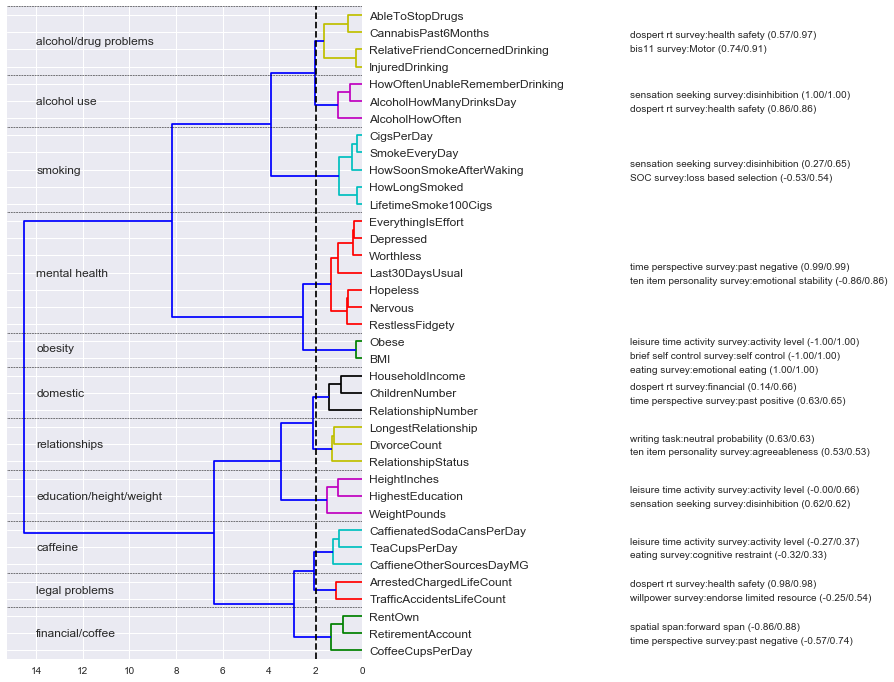

In [26]:
fig=plt.figure(figsize=(14,12))
plt.subplot(1,2,1)
d=dendrogram(k,orientation='left',
             labels=list(df_resid.T.index),
             color_threshold=dthresh,leaf_font_size=12)
plt.plot([dthresh,dthresh],[0,500],'k--')

omult=10
breaks=[]

for i in range(len(d['ivl'])):
    if i>0:
        if clustdict[d['ivl'][i]]==clustdict[d['ivl'][i-1]]:
            continue
    #print(clustdict[d['ivl'][i]],clustdict[d['ivl'][i-1]])
    breaks.append(i)
breaks.append(len(d['ivl']))
replace_sets=[('.',':'),('_',' '),('selection optimization compensation','SOC'),
             ('theories of ','')]

for i in range(1,len(breaks)):
    plt.plot([0,20],[breaks[i]*omult,breaks[i]*omult],'k--',linewidth=0.5)
    if numpy.sum(impdata[clustdict[d['ivl'][breaks[i-1]]]]['meanabs']==1)>2:
        nfeats=numpy.sum(impdata[clustdict[d['ivl'][breaks[i-1]]]]['meanabs']==1).astype('int')
    else:
        nfeats=2
    for j in range(nfeats):
        vartitle=impdata[clustdict[d['ivl'][breaks[i-1]]]].index[j]
        for r in replace_sets:
            vartitle=vartitle.replace(r[0],r[1])
        plt.text(-11.5,0.5*(breaks[i]+breaks[i-1])*omult-j*8+nfeats,
             '%s (%0.2f/%0.2f)'%(vartitle,
                       impdata[clustdict[d['ivl'][breaks[i-1]]]]['meanimp'][j],
                        impdata[clustdict[d['ivl'][breaks[i-1]]]]['meanabs'][j]))
    plt.text(14,0.5*(breaks[i]+breaks[i-1])*omult-4+nfeats,
             matchdesc[clustdict[d['ivl'][breaks[i-1]]]],fontsize=12)

plt.savefig('dendrogram.png',dpi=300,pad_inches=8)


## Clustering on predictor loadings


looks pretty crappy

In [90]:
surveyfiles=glob.glob('/Users/poldrack/code/Self_Regulation_Ontology/prediction_analyses/R_exports_lasso/features/survey*')
dropvars=['Age','Sex']
loadingdata={'survey':None}
include_task=False

for f in surveyfiles:
    varname=f.split('survey')[1].split('_')[1]
    for d in dropvars:
        if f.find(d)>-1:
            continue
    sdata=pandas.read_csv(f).mean(0)
    if include_task:
        tf=f.replace('features/survey_','features/task_')
        if not os.path.exists(tf):
            print('skipping',varname)
            continue
        tdata=pandas.read_csv(tf).mean(0)
        alldata=pandas.concat((tdata,sdata))
    else:
        alldata=sdata
    if loadingdata['survey'] is None:
        loadingdata['survey']=pandas.DataFrame({varname:alldata})
    else:
        loadingdata['survey'][varname]=alldata
        
loadingdata['survey']=loadingdata['survey'].drop('Age').drop('Sex')
del loadingdata['survey']['Age']
del loadingdata['survey']['Sex']
allvars=[i for i in list(loadingdata['survey'].columns) if not i.find('.binarized')>-1]
for c in allvars:
    if '%s.binarized'%c in loadingdata['survey']:
        del loadingdata['survey']['%s.binarized'%c]

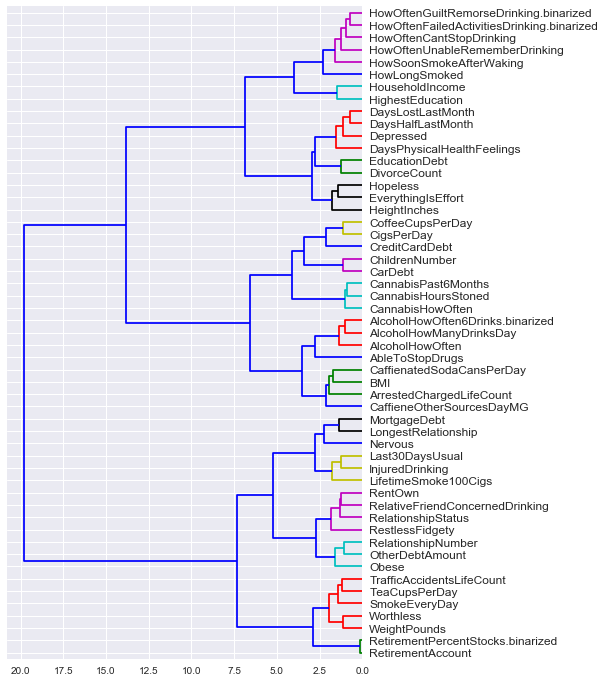

In [91]:
dist=1-loadingdata['survey'].corr(method='spearman')
k=ward(numpy.triu(dist))
c=cut_tree(k,height=dthresh)
ll=leaves_list(k)

fig=plt.figure(figsize=(14,12))
plt.subplot(1,2,1)
d=dendrogram(k,orientation='left',
             labels=list(loadingdata['survey'].T.index),
             color_threshold=dthresh,leaf_font_size=12)

matches={}
matchnums={}
clustdict={}
for i in numpy.unique(c):
    matches[i]=[]
    matchnums[i]=[]
    for j in numpy.where(c==i)[0]:
        matches[i].append(loadingdata['survey'].columns[j])
        clustdict[loadingdata['survey'].columns[j]]=i
        matchnums[i].append(j)


## task-specific prediction analyses - for Aim 2 task selection

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
AbleToStopDrugs,AUROC,0.598054,0.559025,0.039029,0.507249,0.006000,0.414687,"[[attention_network_task.hddm_drift, attention_network_task.hddm_thresh, Age]]"
AlcoholHowOften.binarized,AUROC,0.504367,0.468331,0.036035,NaN,0.032032,0.941128,"[[attention_network_task.alerting_hddm_drift, attention_network_task.orienting_hddm_drift, attention_network_task.hddm_drift]]"
LifetimeSmoke100Cigs,AUROC,0.609417,0.601179,0.008238,0.624026,0.029000,0.924960,"[[Age, attention_network_task.hddm_thresh, attention_network_task.conflict_hddm_drift]]"
HowLongSmoked,r2,0.083621,0.076529,0.007092,0.111007,0.004000,0.302827,"[[attention_network_task.alerting_hddm_drift, attention_network_task.hddm_drift, attention_network_task.hddm_non_decision]]"


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
AlcoholHowOften.binarized,AUROC,0.533756,0.468331,0.065425,NaN,0.000,0.000000,"[[columbia_card_task_hot.information_use, columbia_card_task_hot.probability_sensitivity, columbia_card_task_hot.avg_cards_chosen]]"
CigsPerDay.binarized,AUROC,0.577277,0.548350,0.028927,0.500738,0.000,0.000000,"[[columbia_card_task_hot.gain_sensitivity, Age, columbia_card_task_hot.avg_cards_chosen]]"
SmokeEveryDay.binarized,AUROC,0.580040,0.551976,0.028064,0.507247,0.002,0.161530,"[[columbia_card_task_hot.avg_cards_chosen, columbia_card_task_hot.gain_sensitivity, Age]]"
HowSoonSmokeAfterWaking.binarized,AUROC,0.571088,0.553871,0.017217,0.497779,0.020,0.827548,"[[columbia_card_task_hot.gain_sensitivity, Age, columbia_card_task_hot.avg_cards_chosen]]"


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
AlcoholHowOften.binarized,AUROC,0.529463,0.468331,0.061132,NaN,0.000,0.000000,"[[discount_titrate.percent_patient, Sex, Age]]"
HowSoonSmokeAfterWaking.binarized,AUROC,0.579132,0.553871,0.025261,NaN,0.003,0.234634,"[[Age, discount_titrate.percent_patient, Sex]]"
CigsPerDay.binarized,AUROC,0.565086,0.548350,0.016737,NaN,0.027,0.907569,"[[Age, discount_titrate.percent_patient, Sex]]"
AlcoholHowOften,r2,0.004900,0.001031,0.003868,0.01749,0.018,0.797786,"[[discount_titrate.percent_patient, Sex, Age]]"


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
AbleToStopDrugs,AUROC,0.599283,0.559025,0.040257,NaN,0.004,0.302827,"[[dot_pattern_expectancy.hddm_drift, Age, Sex]]"
HowOftenUnableRememberDrinking.binarized,AUROC,0.567968,0.540953,0.027015,0.511364,0.032,0.944677,"[[Age, Sex, dot_pattern_expectancy.hddm_non_decision]]"


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
AlcoholHowOften.binarized,AUROC,0.510210,0.468331,0.041879,NaN,0.013013,0.671548,"[[kirby.hyp_discount_rate_large.logTr, Sex, Age]]"
HowSoonSmokeAfterWaking.binarized,AUROC,0.591011,0.553871,0.037139,0.499063,0.000000,0.000000,"[[kirby.hyp_discount_rate_large.logTr, Age, Sex]]"
CigsPerDay.binarized,AUROC,0.580167,0.548350,0.031817,0.496668,0.000000,0.000000,"[[kirby.hyp_discount_rate_large.logTr, Age, kirby.hyp_discount_rate_small.logTr]]"
SmokeEveryDay.binarized,AUROC,0.572904,0.551976,0.020928,0.542168,0.018000,0.782547,"[[kirby.hyp_discount_rate_large.logTr, Age, Sex]]"
SmokeEveryDay,r2,0.022863,0.006009,0.016854,0.046018,0.000000,0.000000,"[[kirby.hyp_discount_rate_large.logTr, Age, Sex]]"
CigsPerDay,r2,0.023835,0.009213,0.014622,0.045825,0.000000,0.000000,"[[Age, kirby.hyp_discount_rate_large.logTr, kirby.hyp_discount_rate_small.logTr]]"
HowSoonSmokeAfterWaking,r2,0.004074,0.000906,0.003168,0.016350,0.007000,0.453443,"[[Sex, kirby.hyp_discount_rate_large.logTr, Age]]"


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
AbleToStopDrugs,AUROC,0.614156,0.559025,0.055131,0.506304,0.0,0.0,"[[stop_signal.SSRT_low, Age, Sex]]"
AlcoholHowManyDrinksDay.binarized,AUROC,0.564877,0.524419,0.040458,0.533085,0.0,0.0,"[[stop_signal.SSRT_low, stop_signal.proactive_slowing, Age]]"
AlcoholHowManyDrinksDay,r2,0.013439,0.002484,0.010955,0.043136,0.0,0.0,"[[stop_signal.SSRT_low, stop_signal.proactive_slowing, Sex]]"


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
AlcoholHowOften.binarized,AUROC,0.509916,0.468331,0.041585,NaN,0.013013,0.692370,"[[stroop.hddm_non_decision, stroop.hddm_thresh, Sex]]"
CannabisHoursStoned,r2,0.010971,0.002483,0.008489,0.052597,0.029000,0.924960,"[[stroop.stroop_hddm_drift, stroop.hddm_non_decision, Age]]"
BMI,r2,0.007071,0.001352,0.005720,0.028712,0.014000,0.714868,"[[stroop.hddm_drift, Age, stroop.stroop_hddm_drift]]"


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
AlcoholHowOften.binarized,AUROC,0.566998,0.468331,0.098667,NaN,0.000,0.000000,"[[threebytwo.hddm_drift, threebytwo.cue_switch_cost_hddm_drift_100.0, threebytwo.hddm_thresh]]"
HowOftenUnableRememberDrinking.binarized,AUROC,0.576567,0.540953,0.035615,NaN,0.006,0.411154,"[[threebytwo.hddm_drift, Age, Sex]]"
AlcoholHowManyDrinksDay.binarized,AUROC,0.548701,0.524419,0.024282,0.505497,0.019,0.811547,"[[threebytwo.hddm_non_decision, Age, Sex]]"
AlcoholHowOften,r2,0.010415,0.001031,0.009384,0.030603,0.001,0.085195,"[[threebytwo.hddm_drift, Sex, threebytwo.cue_switch_cost_hddm_drift_100.0]]"


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
RelativeFriendConcernedDrinking,r2,0.009924,0.001810,0.008114,0.034302,0.000,0.000000,"[[tower_of_london.num_extra_moves, tower_of_london.num_optimal_solutions, tower_of_london.planning_time]]"
HowSoonSmokeAfterWaking,r2,0.002993,0.000906,0.002087,0.006512,0.043,0.979994,"[[Sex, tower_of_london.num_extra_moves, Age]]"


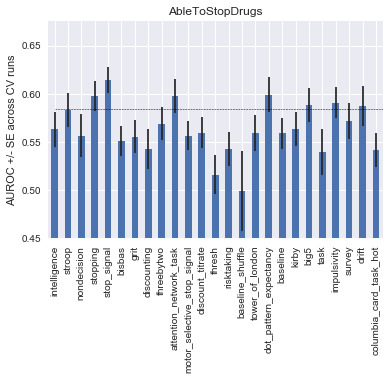

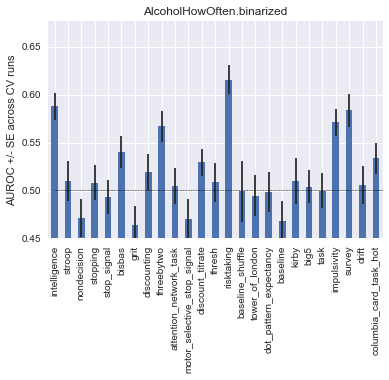

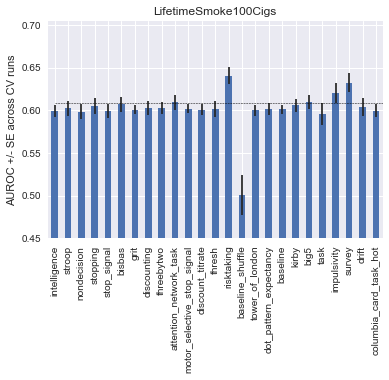

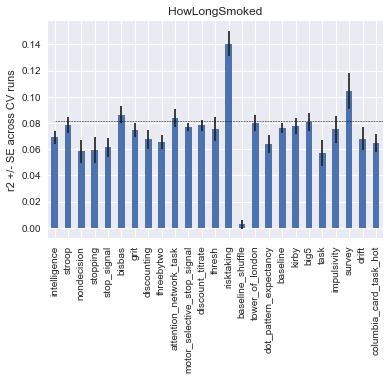

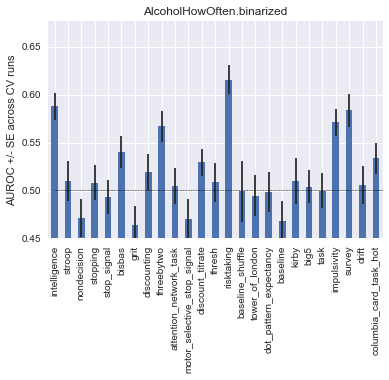

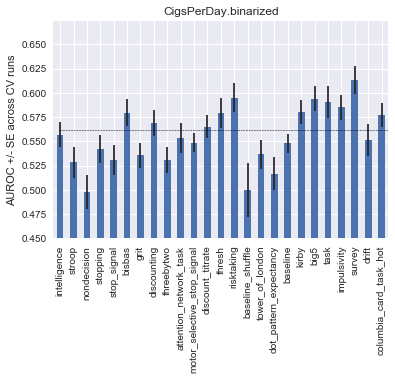

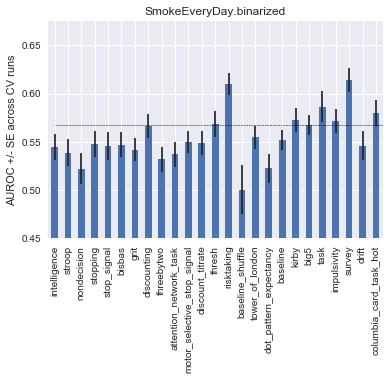

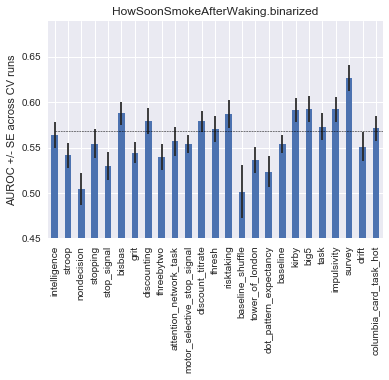

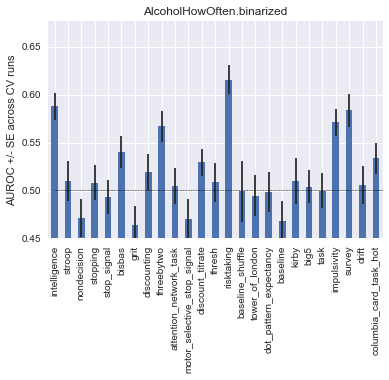

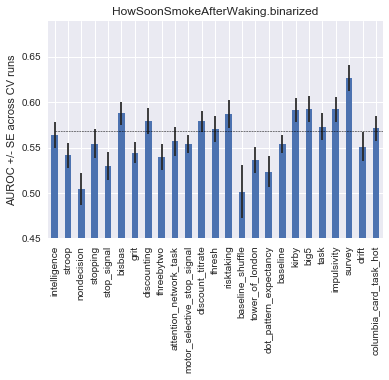

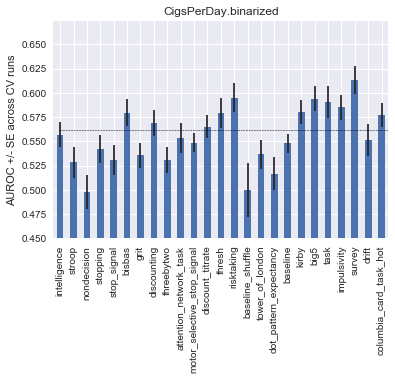

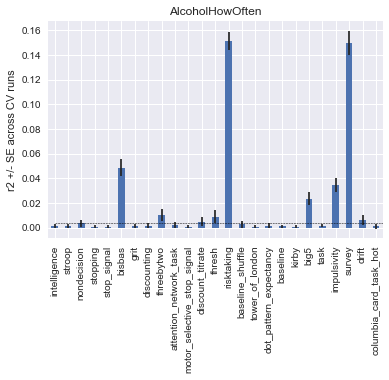

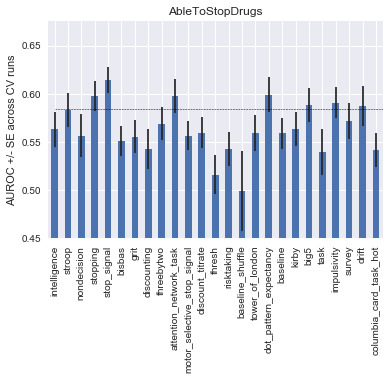

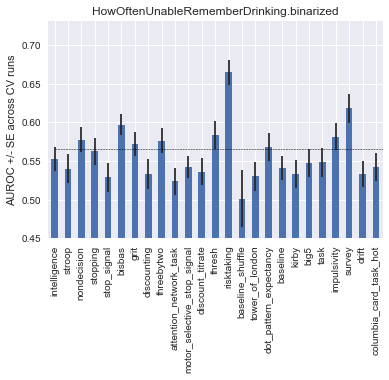

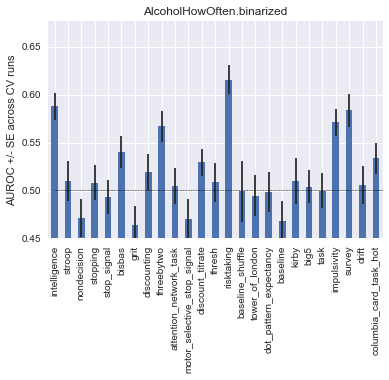

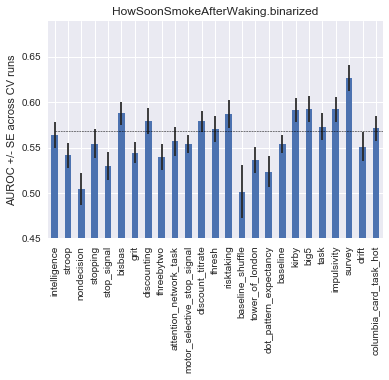

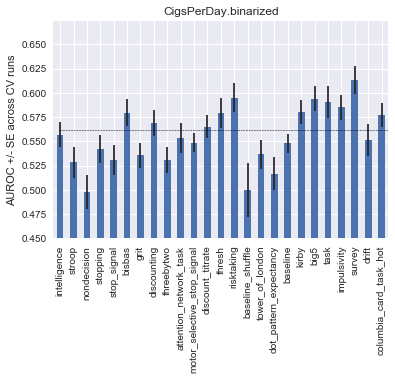

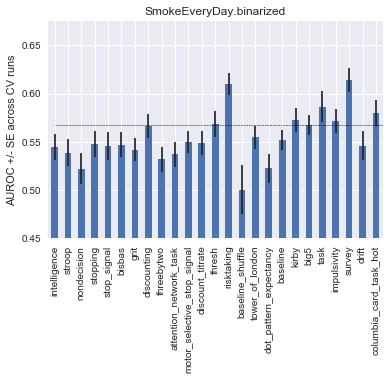

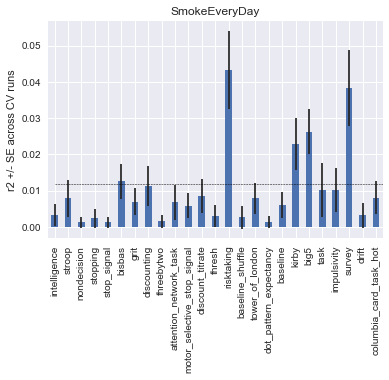

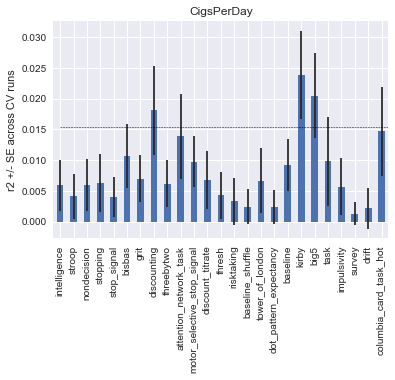

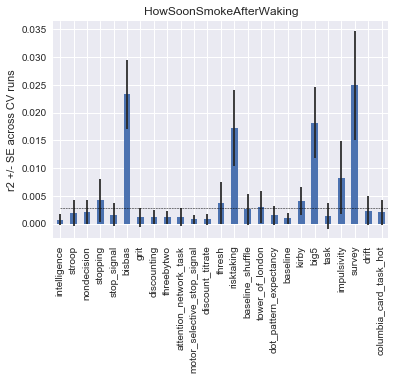

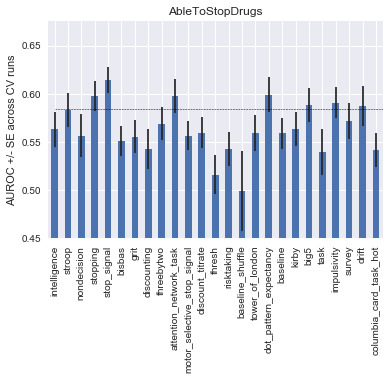

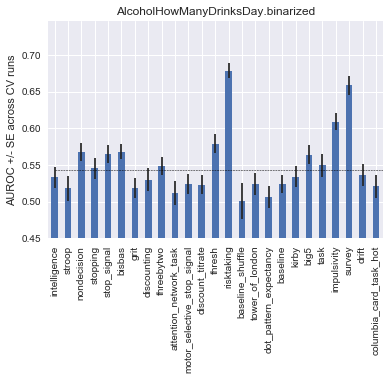

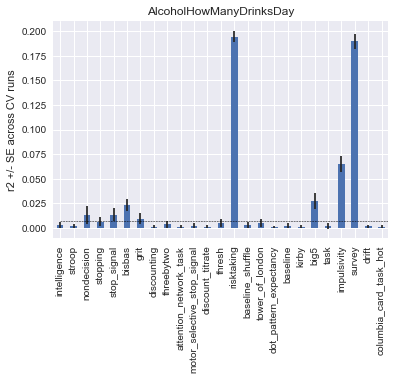

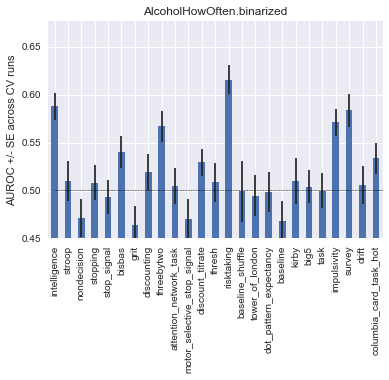

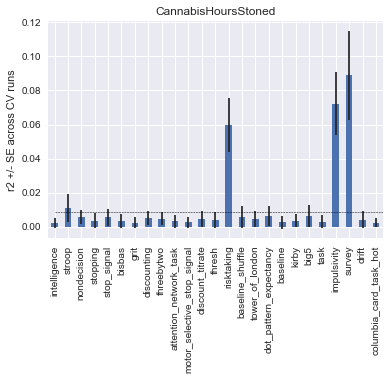

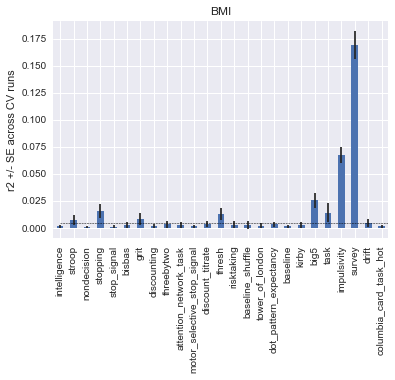

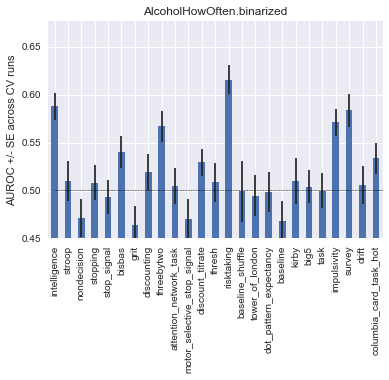

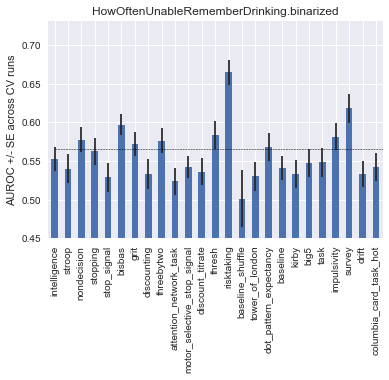

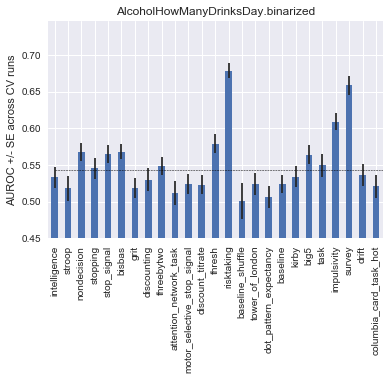

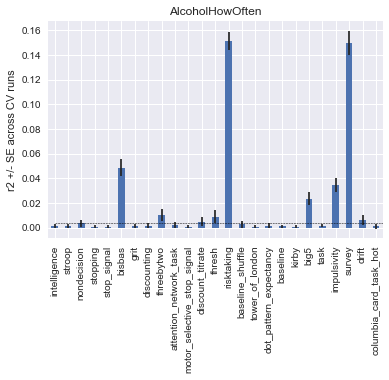

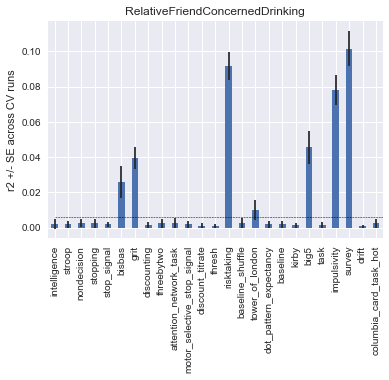

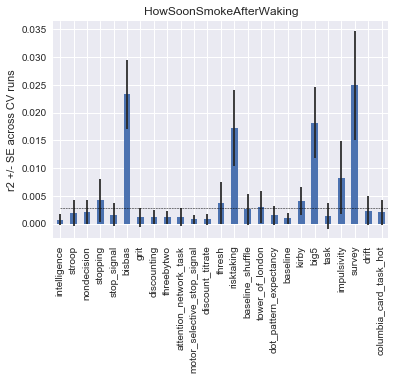

In [122]:
tasks=['attention_network_task', 
       'columbia_card_task_hot', 'discount_titrate', 
       'dot_pattern_expectancy',
       'kirby', 'motor_selective_stop_signal', 'stop_signal', 
       'stroop', 
       'threebytwo', 'tower_of_london']

for t in tasks:
    k=(t,'baseline')
    sigp[k]=pvals[k].query('p_unc <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
    imp=get_importance_list(sigp[k],k[0],features)
    sigp[k]=sigp[k].join(imp)
    display(sigp[k])
    for v in sigp[k].index:
        plotvars(v,pvals,datasets,allvars)

## Factor analysis on outcome measures 
Exploratory - don't use this

In [165]:
%%R -i df_resid -o scores


dropvars <- names(df_resid) %in% c("HeightInches", "WeightPounds", "CigsPerDay") 
print(dropvars)
df <- df_resid[,!dropvars]


library(psych)
vss.result=VSS(df,16,fm='mle',plot=FALSE)
print(vss.result)
nfactor=which.min(vss.result$vss.stats$BIC)
fa.result=fa(df,nfactors=nfactor,fm='mle')
print(fa.result,cut=0.2)
scores=factor.scores(df,fa.result,method='tenBerge')$scores
#clst=iclust(df_resid)

/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In factor.stats, I could not find the RMSEA upper bound . Sorry about that

  warnings.warn(x, RRuntimeWarning)


 [1] FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[37] FALSE FALSE

Very Simple Structure
Call: vss(x = x, n = n, rotate = rotate, diagonal = diagonal, fm = fm, 
    n.obs = n.obs, plot = plot, title = title, use = use, cor = cor)
Although the VSS complexity 1 shows  14  factors, it is probably more reasonable to think about  5  factors
VSS complexity 2 achieves a maximimum of 0.73  with  16  factors

The Velicer MAP achieves a minimum of 0.01  with  6  factors 
BIC achieves a minimum of  -1631.38  with  6  factors
Sample Size adjusted BIC achieves a minimum of  -522  with  10  factors

Statistics by number of factors 
   vss1 vss2   map dof chisq     prob sqresid  fit RMSEA   BIC SABIC complex
1  0.32 0.00 0.028 560  4162  0.0e+00    47.4 0.32 0.111   658  2435     1.0
2  0.52 0.55 0.014 526  2510 2.9e-255 

In [166]:
scores_df=pandas.DataFrame(scores,columns=['smoking severity','mental illness',
                                           'smoking','obesity',
                                           'alcohol','domestic'],index=df_resid.index)
scores_df.to_csv("../Data/Derived_Data/Complete_10-08-2017/factor_scores.csv")

In [152]:
?scores_df.to_csv
